In [15]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
from scipy.linalg import svd, expm
import time
from numpy import linalg as LA
from scipy.linalg import hadamard, subspace_angles
from numpy.linalg import matrix_rank
from scipy.linalg import expm, svd
from scipy import linalg
import math

In [519]:
# Define functions

def gen_syn_data(M, N, dim_lat, nu):
    # Extracting A and B matrices from M
    A = np.array(M)[:, 0:dim_lat]
    B = np.array(M)[:, dim_lat:dim_lat + nu]

    # System dynamics - Non-IID
    X = np.zeros((dim_lat + nu, N))
    Y = np.zeros((dim_lat, N + 1))
    sigu = 1
    sigw = 1

    rho = 5
    Sigma = rho * np.eye(dim_lat) + 2 * np.random.rand(dim_lat, dim_lat)
    Sigma_W = 0.5 * (Sigma + Sigma.T)

    Sigma_y = linalg.solve_discrete_lyapunov(A, (sigu ** 2) * np.dot(B, B.T) + Sigma_W)

    Ys = sqrtm(Sigma_y) @ np.random.normal(0, 1, (dim_lat, 1))
    Y[:,0] = Ys[:,0]

    for t in range(N):
        u = np.random.normal(0, sigu, (nu, 1))
        w = sqrtm(Sigma_W) @ np.random.normal(0, 1, (dim_lat, 1))
        X[:dim_lat, t] = Y[:, t]
        X[dim_lat:dim_lat+nu] = u
        Y_t_1 = np.dot(M, X[:, t]) + w
        Y[:, t+1] = Y_t_1[:,0]

    Y = Y[:, 1:]  # Remove the first column from Y

    return X, Y


def subspace_distance(Phi_1, Phi_2):
    r = Phi_1.shape[0]
    distance = np.sqrt(r - np.linalg.norm(Phi_1.dot(Phi_2.T), 'fro') ** 2)
    return distance


def grad_F(F,Phi,j,X,Y,lambda_F,ny,r,sigma):
    
    M = len(F)
    T = len(X)
    
    sum_term = 0
    
    for t in range(T):
        Phi_term = np.zeros([ny,r])
        Phi_term[j,:] = np.dot(Phi,X[:,t]).T
        
        sum_term = sum_term + (1/(sigma**2))*np.dot((Y[:,t] - np.dot(np.dot(F,Phi),X[:,t])).T,Phi_term)
    
    grad_weight = -(F[j,:])/(lambda_F**2) + sum_term
    
    return grad_weight


def grad_Phi(F,Phi,j,Xc,Yc,lambda_Phi,sigma):
    
    M = len(F)
    T = len(Xc)
    
    sum_term = 0
    
    for i in range(M): 
        for t in range(T):
            X = np.zeros([Xc[i][:,t].shape[0],1])
            X[:,0] = Xc[i][:,t]
            sum_term = sum_term + (1/(sigma**2))*np.dot(F[i].T,Yc[i][:,t]-np.dot(np.dot(F[i],Phi),X))*X[j,0]
    
    grad_phi = np.zeros([r,1])
    grad_phi[:,0] = Phi[:,j]      
    grad_phi=-grad_phi/(lambda_phi**2) + sum_term
    return grad_phi



def CAMAP(Phi_hat, F, K, H, M, Phi_true, nx, nu, r, N, dim_lat, lambda_phi, lambda_F, eta_F, eta_phi, sigma, X, Y):
    

    Error_rep = []
    Log_joint_iter = []
    l=0
    F_it = []
    Phi_hat_it=[]
    for k in range(K):
        F_it.append(F)
        Phi_hat_it.append(Phi_hat)
        
        
        start_time = time.time()
        
        # Calculating subspace distance
        Error_rep.append(subspace_distance(Phi_true, Phi_hat))
        
        
       
        Xc=[]
        Yc=[]
        
        for h in range(H): # For all tasks do
           
            for j in range(ny):
                F[h][j,:] = F[h][j,:] + eta_F*grad_F(F[h],Phi_hat,int(j),X[h],Y[h],lambda_F,ny,r,sigma)
                
        for j in range(nx):
            Phi_hat[:,j] = Phi_hat[:,j] + (eta_phi)*grad_Phi(F,Phi_hat,int(j),X,Y,lambda_phi,sigma)[:,0]
        
        eta_phi = eta_phi/1.0065
    
        
        end_time = time.time()
        print(f"Iteration: {l}, Subspace Dist: {Error_rep[l]}, Time: {end_time - start_time}")
        
        
        if math.isnan(Error_rep[l]):
            Error_rep = Error_rep[:-1]
            eta_phi = eta_phi/100
            eta_F = eta_F/100
            Phi_hat = Phi_hat_it[l-1]
            F = F_it[l-1]
            break 
        else:
            l=l+1
        
        
    return Error_rep, Phi_hat, F


$\textbf{System Parameter:}$

In [520]:
nx = 4
nu = 2

r = nx + nu  # rank

dim_lat = 25  # latent space dimension

ny = dim_lat
nx = dim_lat + nu

H = 50 # number of tasks
N = 100
lambda_F = 10

# Randomly generate the true representation
Phi, _, _ = svd(np.random.randn(dim_lat + nu, dim_lat + nu))
Phi = Phi[0:r, :]
Phi_true = Phi

# Randomly generate the nominal task weights F
F_0 = np.zeros([ny,r])

for i in range(ny):
    for j in range(r):
        F_0[i,j] = np.random.normal(loc=0, scale=lambda_F)

F_0 = F_0 / np.linalg.norm(F_0)

M_0 = np.dot(F_0, Phi)  # Nominal operator M

# Generating different tasks weights
H = 25
scale = 0.001
F = []
P = []
for h in range(H):
    L = scale * np.random.randn(dim_lat, dim_lat)
    skewL = (L - L.T) / 2
    P.append(expm(skewL))
    F.append(np.dot(P[h], F_0))

M = []
for h in range(H):
    M.append(np.dot(F[h], Phi))  # Generating the true operators M for H different tasks

In [521]:
#Initializing the representation
L = np.random.randn(dim_lat + nu, dim_lat + nu)
skewL = (L - L.T) / 2
rot = expm(skewL)

X = []
Y = []
for h in range(H):
    [X_h,Y_h] = gen_syn_data(M[h], N, dim_lat, nu)
    X.append(X_h)
    Y.append(Y_h)

$\textbf{Coordinate Ascent MAP Estimation:}$

In [522]:
K = 2500 #number of global iterations
N = 100  #number of samples

lambda_phi = 7.5
sigma = 0.06

eta_F = 1e-6
eta_phi = 0.75e-6

Phi_hat = Phi_true.dot(rot)

$\textbf{Single task}\;\ (M = 1)$

In [456]:
H = 1
F_init = []
X_data = []
Y_data = []

for i in range(H):
    F_init.append(F[i])
    X_data.append(X[i])
    Y_data.append(Y[i])

Phi_hat = Phi_true.dot(rot)
Error_CAMAP_1, _, _ = CAMAP(Phi_hat, F_init, K, H, M, Phi_true, nx, nu, r, N, dim_lat, lambda_phi, lambda_F, eta_F, eta_phi,sigma, X_data, Y_data)

Iteration: 0, Subspace Dist: 2.088145555059889, Time: 0.01396322250366211
Iteration: 1, Subspace Dist: 2.0891448482963804, Time: 0.013703107833862305
Iteration: 2, Subspace Dist: 2.0889716793502595, Time: 0.010826826095581055
Iteration: 3, Subspace Dist: 2.0888986828446727, Time: 0.010999679565429688
Iteration: 4, Subspace Dist: 2.088946792120501, Time: 0.009940862655639648
Iteration: 5, Subspace Dist: 2.0890052285498926, Time: 0.009857416152954102
Iteration: 6, Subspace Dist: 2.08899397282539, Time: 0.009924888610839844
Iteration: 7, Subspace Dist: 2.0888695157822834, Time: 0.010042428970336914
Iteration: 8, Subspace Dist: 2.0886118192289147, Time: 0.009151458740234375
Iteration: 9, Subspace Dist: 2.0882140589941516, Time: 0.009973526000976562
Iteration: 10, Subspace Dist: 2.0876764846813454, Time: 0.010972738265991211
Iteration: 11, Subspace Dist: 2.0870030216022952, Time: 0.011324644088745117
Iteration: 12, Subspace Dist: 2.0861994460226385, Time: 0.010941267013549805
Iteration: 13,

Iteration: 109, Subspace Dist: 1.9405214752903484, Time: 0.015473365783691406
Iteration: 110, Subspace Dist: 1.939607808457216, Time: 0.016391277313232422
Iteration: 111, Subspace Dist: 1.9387041822303017, Time: 0.011940479278564453
Iteration: 112, Subspace Dist: 1.9378104549619075, Time: 0.01296544075012207
Iteration: 113, Subspace Dist: 1.9369264866562486, Time: 0.012966632843017578
Iteration: 114, Subspace Dist: 1.9360521390045609, Time: 0.013093233108520508
Iteration: 115, Subspace Dist: 1.935187275415573, Time: 0.011000394821166992
Iteration: 116, Subspace Dist: 1.9343317610415036, Time: 0.00997304916381836
Iteration: 117, Subspace Dist: 1.9334854627997717, Time: 0.010590791702270508
Iteration: 118, Subspace Dist: 1.9326482493906298, Time: 0.010008811950683594
Iteration: 119, Subspace Dist: 1.9318199913109357, Time: 0.009993553161621094
Iteration: 120, Subspace Dist: 1.931000560864293, Time: 0.010003089904785156
Iteration: 121, Subspace Dist: 1.930189832167786, Time: 0.01001143455

Iteration: 229, Subspace Dist: 1.875538576407498, Time: 0.013437509536743164
Iteration: 230, Subspace Dist: 1.8752271728693195, Time: 0.013001203536987305
Iteration: 231, Subspace Dist: 1.8749180635912246, Time: 0.01096796989440918
Iteration: 232, Subspace Dist: 1.874611226937779, Time: 0.011976242065429688
Iteration: 233, Subspace Dist: 1.8743066415706688, Time: 0.009734630584716797
Iteration: 234, Subspace Dist: 1.8740042864433804, Time: 0.009874105453491211
Iteration: 235, Subspace Dist: 1.87370414079598, Time: 0.010927438735961914
Iteration: 236, Subspace Dist: 1.8734061841499974, Time: 0.010172128677368164
Iteration: 237, Subspace Dist: 1.873110396303402, Time: 0.009967327117919922
Iteration: 238, Subspace Dist: 1.8728167573256806, Time: 0.011002540588378906
Iteration: 239, Subspace Dist: 1.8725252475530072, Time: 0.008875846862792969
Iteration: 240, Subspace Dist: 1.8722358475835041, Time: 0.011968135833740234
Iteration: 241, Subspace Dist: 1.8719485382725998, Time: 0.01396155357

Iteration: 346, Subspace Dist: 1.8506004876916282, Time: 0.011001348495483398
Iteration: 347, Subspace Dist: 1.8504610475478813, Time: 0.012902975082397461
Iteration: 348, Subspace Dist: 1.850322523340467, Time: 0.010978460311889648
Iteration: 349, Subspace Dist: 1.8501849087919515, Time: 0.009973526000976562
Iteration: 350, Subspace Dist: 1.8500481976748182, Time: 0.010009288787841797
Iteration: 351, Subspace Dist: 1.8499123838109013, Time: 0.01096653938293457
Iteration: 352, Subspace Dist: 1.8497774610708324, Time: 0.010015487670898438
Iteration: 353, Subspace Dist: 1.8496434233734937, Time: 0.009934186935424805
Iteration: 354, Subspace Dist: 1.849510264685482, Time: 0.011004447937011719
Iteration: 355, Subspace Dist: 1.8493779790205822, Time: 0.009976387023925781
Iteration: 356, Subspace Dist: 1.849246560439247, Time: 0.012316465377807617
Iteration: 357, Subspace Dist: 1.8491160030480893, Time: 0.010939359664916992
Iteration: 358, Subspace Dist: 1.8489863009993783, Time: 0.010004997

Iteration: 465, Subspace Dist: 1.8390371083725954, Time: 0.014256477355957031
Iteration: 466, Subspace Dist: 1.838973022308287, Time: 0.012965917587280273
Iteration: 467, Subspace Dist: 1.8389093518587305, Time: 0.012003183364868164
Iteration: 468, Subspace Dist: 1.8388460943180291, Time: 0.011835098266601562
Iteration: 469, Subspace Dist: 1.8387832469981467, Time: 0.011969327926635742
Iteration: 470, Subspace Dist: 1.8387208072287826, Time: 0.012973785400390625
Iteration: 471, Subspace Dist: 1.838658772357248, Time: 0.009575605392456055
Iteration: 472, Subspace Dist: 1.8385971397483418, Time: 0.012531757354736328
Iteration: 473, Subspace Dist: 1.838535906784232, Time: 0.012933731079101562
Iteration: 474, Subspace Dist: 1.8384750708643307, Time: 0.010971546173095703
Iteration: 475, Subspace Dist: 1.8384146294051773, Time: 0.011003494262695312
Iteration: 476, Subspace Dist: 1.8383545798403198, Time: 0.012000083923339844
Iteration: 477, Subspace Dist: 1.8382949196201954, Time: 0.01094079

Iteration: 587, Subspace Dist: 1.8336219482158322, Time: 0.011966466903686523
Iteration: 588, Subspace Dist: 1.833592949932507, Time: 0.012031793594360352
Iteration: 589, Subspace Dist: 1.8335641393873816, Time: 0.010937213897705078
Iteration: 590, Subspace Dist: 1.8335355153631763, Time: 0.00997471809387207
Iteration: 591, Subspace Dist: 1.8335070766505195, Time: 0.01092672348022461
Iteration: 592, Subspace Dist: 1.8334788220478964, Time: 0.009975671768188477
Iteration: 593, Subspace Dist: 1.8334507503615984, Time: 0.01097726821899414
Iteration: 594, Subspace Dist: 1.8334228604056713, Time: 0.008899927139282227
Iteration: 595, Subspace Dist: 1.8333951510018667, Time: 0.009917736053466797
Iteration: 596, Subspace Dist: 1.833367620979588, Time: 0.008975982666015625
Iteration: 597, Subspace Dist: 1.8333402691758454, Time: 0.010529041290283203
Iteration: 598, Subspace Dist: 1.8333130944352019, Time: 0.011917352676391602
Iteration: 599, Subspace Dist: 1.8332860956097277, Time: 0.0119194984

Iteration: 708, Subspace Dist: 1.8311836946975009, Time: 0.014961481094360352
Iteration: 709, Subspace Dist: 1.8311704744231825, Time: 0.012890338897705078
Iteration: 710, Subspace Dist: 1.831157339648882, Time: 0.012965202331542969
Iteration: 711, Subspace Dist: 1.8311442898210242, Time: 0.009976387023925781
Iteration: 712, Subspace Dist: 1.8311313243896246, Time: 0.01328277587890625
Iteration: 713, Subspace Dist: 1.8311184428082659, Time: 0.011955022811889648
Iteration: 714, Subspace Dist: 1.831105644534074, Time: 0.01196908950805664
Iteration: 715, Subspace Dist: 1.8310929290276958, Time: 0.009970664978027344
Iteration: 716, Subspace Dist: 1.8310802957532755, Time: 0.012967348098754883
Iteration: 717, Subspace Dist: 1.8310677441784342, Time: 0.0109710693359375
Iteration: 718, Subspace Dist: 1.8310552737742427, Time: 0.010553598403930664
Iteration: 719, Subspace Dist: 1.8310428840152044, Time: 0.011639833450317383
Iteration: 720, Subspace Dist: 1.8310305743792301, Time: 0.01296639442

Iteration: 826, Subspace Dist: 1.8300900721631825, Time: 0.013586044311523438
Iteration: 827, Subspace Dist: 1.830083922428058, Time: 0.012518882751464844
Iteration: 828, Subspace Dist: 1.8300778124382202, Time: 0.01101231575012207
Iteration: 829, Subspace Dist: 1.8300717419366261, Time: 0.012958526611328125
Iteration: 830, Subspace Dist: 1.8300657106678972, Time: 0.012000322341918945
Iteration: 831, Subspace Dist: 1.830059718378309, Time: 0.009897232055664062
Iteration: 832, Subspace Dist: 1.830053764815778, Time: 0.009936809539794922
Iteration: 833, Subspace Dist: 1.830047849729855, Time: 0.011003494262695312
Iteration: 834, Subspace Dist: 1.830041972871711, Time: 0.009015083312988281
Iteration: 835, Subspace Dist: 1.8300361339941287, Time: 0.01066732406616211
Iteration: 836, Subspace Dist: 1.8300303328514913, Time: 0.009934186935424805
Iteration: 837, Subspace Dist: 1.8300245691997719, Time: 0.010004281997680664
Iteration: 838, Subspace Dist: 1.8300188427965234, Time: 0.009834527969

Iteration: 947, Subspace Dist: 1.8295727180175974, Time: 0.013193130493164062
Iteration: 948, Subspace Dist: 1.8295699112713848, Time: 0.012964248657226562
Iteration: 949, Subspace Dist: 1.8295671226578905, Time: 0.011937856674194336
Iteration: 950, Subspace Dist: 1.829564352059929, Time: 0.010006904602050781
Iteration: 951, Subspace Dist: 1.829561599361073, Time: 0.013024568557739258
Iteration: 952, Subspace Dist: 1.829558864445648, Time: 0.013933181762695312
Iteration: 953, Subspace Dist: 1.8295561471987272, Time: 0.012899637222290039
Iteration: 954, Subspace Dist: 1.8295534475061273, Time: 0.011979341506958008
Iteration: 955, Subspace Dist: 1.8295507652544034, Time: 0.012006521224975586
Iteration: 956, Subspace Dist: 1.8295481003308445, Time: 0.012775897979736328
Iteration: 957, Subspace Dist: 1.8295454526234671, Time: 0.011973381042480469
Iteration: 958, Subspace Dist: 1.829542822021014, Time: 0.010817766189575195
Iteration: 959, Subspace Dist: 1.8295402084129455, Time: 0.012805700

Iteration: 1066, Subspace Dist: 1.8293391588581893, Time: 0.013963937759399414
Iteration: 1067, Subspace Dist: 1.8293378608558444, Time: 0.01396489143371582
Iteration: 1068, Subspace Dist: 1.8293365712375014, Time: 0.016695022583007812
Iteration: 1069, Subspace Dist: 1.8293352899489976, Time: 0.013962507247924805
Iteration: 1070, Subspace Dist: 1.8293340169365204, Time: 0.009972095489501953
Iteration: 1071, Subspace Dist: 1.8293327521466043, Time: 0.012681722640991211
Iteration: 1072, Subspace Dist: 1.8293314955261308, Time: 0.010993719100952148
Iteration: 1073, Subspace Dist: 1.829330247022323, Time: 0.009975671768188477
Iteration: 1074, Subspace Dist: 1.8293290065827454, Time: 0.009937047958374023
Iteration: 1075, Subspace Dist: 1.829327774155302, Time: 0.009987115859985352
Iteration: 1076, Subspace Dist: 1.8293265496882332, Time: 0.009973287582397461
Iteration: 1077, Subspace Dist: 1.8293253331301138, Time: 0.009973526000976562
Iteration: 1078, Subspace Dist: 1.829324124429851, Time

Iteration: 1185, Subspace Dist: 1.8292311418750817, Time: 0.014972209930419922
Iteration: 1186, Subspace Dist: 1.8292305415393841, Time: 0.011967182159423828
Iteration: 1187, Subspace Dist: 1.8292299450809881, Time: 0.008975505828857422
Iteration: 1188, Subspace Dist: 1.8292293524748493, Time: 0.012022018432617188
Iteration: 1189, Subspace Dist: 1.8292287636960864, Time: 0.009972810745239258
Iteration: 1190, Subspace Dist: 1.8292281787199778, Time: 0.01262664794921875
Iteration: 1191, Subspace Dist: 1.8292275975219616, Time: 0.010808229446411133
Iteration: 1192, Subspace Dist: 1.8292270200776355, Time: 0.012516975402832031
Iteration: 1193, Subspace Dist: 1.829226446362754, Time: 0.011970043182373047
Iteration: 1194, Subspace Dist: 1.8292258763532283, Time: 0.010582685470581055
Iteration: 1195, Subspace Dist: 1.8292253100251257, Time: 0.013962745666503906
Iteration: 1196, Subspace Dist: 1.8292247473546677, Time: 0.013432502746582031
Iteration: 1197, Subspace Dist: 1.8292241883182294, Ti

Iteration: 1306, Subspace Dist: 1.8291806284080279, Time: 0.01396322250366211
Iteration: 1307, Subspace Dist: 1.8291803543091687, Time: 0.0139617919921875
Iteration: 1308, Subspace Dist: 1.8291800819805135, Time: 0.012806415557861328
Iteration: 1309, Subspace Dist: 1.829179811410629, Time: 0.012524127960205078
Iteration: 1310, Subspace Dist: 1.8291795425881563, Time: 0.009821414947509766
Iteration: 1311, Subspace Dist: 1.82917927550181, Time: 0.01203775405883789
Iteration: 1312, Subspace Dist: 1.8291790101403773, Time: 0.01585531234741211
Iteration: 1313, Subspace Dist: 1.8291787464927174, Time: 0.011997461318969727
Iteration: 1314, Subspace Dist: 1.8291784845477623, Time: 0.008942365646362305
Iteration: 1315, Subspace Dist: 1.8291782242945152, Time: 0.010970354080200195
Iteration: 1316, Subspace Dist: 1.8291779657220495, Time: 0.011042356491088867
Iteration: 1317, Subspace Dist: 1.8291777088195111, Time: 0.00993967056274414
Iteration: 1318, Subspace Dist: 1.8291774535761138, Time: 0.0

Iteration: 1425, Subspace Dist: 1.8291578176386754, Time: 0.012943744659423828
Iteration: 1426, Subspace Dist: 1.829157690856389, Time: 0.012923240661621094
Iteration: 1427, Subspace Dist: 1.8291575648928797, Time: 0.012006759643554688
Iteration: 1428, Subspace Dist: 1.82915743974286, Time: 0.009876251220703125
Iteration: 1429, Subspace Dist: 1.829157315401076, Time: 0.010533809661865234
Iteration: 1430, Subspace Dist: 1.8291571918623082, Time: 0.010938644409179688
Iteration: 1431, Subspace Dist: 1.8291570691213703, Time: 0.00897526741027832
Iteration: 1432, Subspace Dist: 1.8291569471731095, Time: 0.011000394821166992
Iteration: 1433, Subspace Dist: 1.8291568260124067, Time: 0.00892496109008789
Iteration: 1434, Subspace Dist: 1.829156705634176, Time: 0.010934829711914062
Iteration: 1435, Subspace Dist: 1.829156586033363, Time: 0.011858940124511719
Iteration: 1436, Subspace Dist: 1.8291564672049478, Time: 0.009030342102050781
Iteration: 1437, Subspace Dist: 1.829156349143942, Time: 0.0

Iteration: 1544, Subspace Dist: 1.8291472666379245, Time: 0.012995719909667969
Iteration: 1545, Subspace Dist: 1.829147207995122, Time: 0.014934778213500977
Iteration: 1546, Subspace Dist: 1.8291471497310392, Time: 0.013957500457763672
Iteration: 1547, Subspace Dist: 1.8291470918432304, Time: 0.011968374252319336
Iteration: 1548, Subspace Dist: 1.8291470343292655, Time: 0.010007858276367188
Iteration: 1549, Subspace Dist: 1.82914697718673, Time: 0.012965917587280273
Iteration: 1550, Subspace Dist: 1.8291469204132251, Time: 0.012370586395263672
Iteration: 1551, Subspace Dist: 1.8291468640063675, Time: 0.014961004257202148
Iteration: 1552, Subspace Dist: 1.8291468079637903, Time: 0.01495981216430664
Iteration: 1553, Subspace Dist: 1.8291467522831393, Time: 0.011968374252319336
Iteration: 1554, Subspace Dist: 1.8291466969620787, Time: 0.011998414993286133
Iteration: 1555, Subspace Dist: 1.8291466419982847, Time: 0.01193690299987793
Iteration: 1556, Subspace Dist: 1.8291465873894515, Time:

Iteration: 1649, Subspace Dist: 1.8291427850865132, Time: 0.014377593994140625
Iteration: 1650, Subspace Dist: 1.8291427553858508, Time: 0.011000633239746094
Iteration: 1651, Subspace Dist: 1.8291427258769966, Time: 0.012981891632080078
Iteration: 1652, Subspace Dist: 1.8291426965587116, Time: 0.010969877243041992
Iteration: 1653, Subspace Dist: 1.829142667429766, Time: 0.01261138916015625
Iteration: 1654, Subspace Dist: 1.8291426384889367, Time: 0.012509346008300781
Iteration: 1655, Subspace Dist: 1.8291426097350085, Time: 0.011968374252319336
Iteration: 1656, Subspace Dist: 1.8291425811667743, Time: 0.01190495491027832
Iteration: 1657, Subspace Dist: 1.8291425527830356, Time: 0.012964487075805664
Iteration: 1658, Subspace Dist: 1.8291425245826003, Time: 0.011918306350708008
Iteration: 1659, Subspace Dist: 1.8291424965642844, Time: 0.008975982666015625
Iteration: 1660, Subspace Dist: 1.8291424687269127, Time: 0.011967897415161133
Iteration: 1661, Subspace Dist: 1.8291424410693158, Tim

Iteration: 1771, Subspace Dist: 1.8291402723979473, Time: 0.015126705169677734
Iteration: 1772, Subspace Dist: 1.8291402589243342, Time: 0.009969949722290039
Iteration: 1773, Subspace Dist: 1.8291402455377335, Time: 0.012105703353881836
Iteration: 1774, Subspace Dist: 1.8291402322375843, Time: 0.01293492317199707
Iteration: 1775, Subspace Dist: 1.8291402190233277, Time: 0.01275324821472168
Iteration: 1776, Subspace Dist: 1.8291402058944093, Time: 0.011394500732421875
Iteration: 1777, Subspace Dist: 1.8291401928502782, Time: 0.011937141418457031
Iteration: 1778, Subspace Dist: 1.8291401798903861, Time: 0.012964487075805664
Iteration: 1779, Subspace Dist: 1.8291401670141894, Time: 0.012966632843017578
Iteration: 1780, Subspace Dist: 1.829140154221148, Time: 0.011967658996582031
Iteration: 1781, Subspace Dist: 1.8291401415107245, Time: 0.011524200439453125
Iteration: 1782, Subspace Dist: 1.8291401288823852, Time: 0.011089324951171875
Iteration: 1783, Subspace Dist: 1.8291401163356003, Tim

Iteration: 1877, Subspace Dist: 1.8291392359031178, Time: 0.01592564582824707
Iteration: 1878, Subspace Dist: 1.829139229123221, Time: 0.011002540588378906
Iteration: 1879, Subspace Dist: 1.8291392223871088, Time: 0.009016752243041992
Iteration: 1880, Subspace Dist: 1.829139215694499, Time: 0.0106201171875
Iteration: 1881, Subspace Dist: 1.82913920904511, Time: 0.009973764419555664
Iteration: 1882, Subspace Dist: 1.8291392024386632, Time: 0.008974552154541016
Iteration: 1883, Subspace Dist: 1.8291391958748808, Time: 0.010005474090576172
Iteration: 1884, Subspace Dist: 1.8291391893534874, Time: 0.00900125503540039
Iteration: 1885, Subspace Dist: 1.8291391828742096, Time: 0.010679006576538086
Iteration: 1886, Subspace Dist: 1.8291391764367748, Time: 0.008982658386230469
Iteration: 1887, Subspace Dist: 1.8291391700409134, Time: 0.010944128036499023
Iteration: 1888, Subspace Dist: 1.8291391636863568, Time: 0.010907411575317383
Iteration: 1889, Subspace Dist: 1.8291391573728377, Time: 0.008

Iteration: 1984, Subspace Dist: 1.8291387109291326, Time: 0.01595330238342285
Iteration: 1985, Subspace Dist: 1.8291387075395322, Time: 0.011996984481811523
Iteration: 1986, Subspace Dist: 1.8291387041718221, Time: 0.012021303176879883
Iteration: 1987, Subspace Dist: 1.8291387008258606, Time: 0.010894298553466797
Iteration: 1988, Subspace Dist: 1.8291386975015074, Time: 0.010791301727294922
Iteration: 1989, Subspace Dist: 1.829138694198623, Time: 0.013967037200927734
Iteration: 1990, Subspace Dist: 1.8291386909170686, Time: 0.013994216918945312
Iteration: 1991, Subspace Dist: 1.8291386876567066, Time: 0.010806083679199219
Iteration: 1992, Subspace Dist: 1.8291386844174, Time: 0.010971784591674805
Iteration: 1993, Subspace Dist: 1.8291386811990133, Time: 0.010969400405883789
Iteration: 1994, Subspace Dist: 1.8291386780014107, Time: 0.010150671005249023
Iteration: 1995, Subspace Dist: 1.8291386748244585, Time: 0.016954421997070312
Iteration: 1996, Subspace Dist: 1.8291386716680231, Time:

Iteration: 2102, Subspace Dist: 1.829138430418568, Time: 0.0168607234954834
Iteration: 2103, Subspace Dist: 1.829138428840512, Time: 0.009938478469848633
Iteration: 2104, Subspace Dist: 1.829138427272647, Time: 0.01293492317199707
Iteration: 2105, Subspace Dist: 1.8291384257149073, Time: 0.01296377182006836
Iteration: 2106, Subspace Dist: 1.8291384241672275, Time: 0.013540983200073242
Iteration: 2107, Subspace Dist: 1.8291384226295428, Time: 0.010010242462158203
Iteration: 2108, Subspace Dist: 1.8291384211017885, Time: 0.011899471282958984
Iteration: 2109, Subspace Dist: 1.8291384195839004, Time: 0.014371395111083984
Iteration: 2110, Subspace Dist: 1.8291384180758148, Time: 0.012955665588378906
Iteration: 2111, Subspace Dist: 1.8291384165774685, Time: 0.011652708053588867
Iteration: 2112, Subspace Dist: 1.8291384150887986, Time: 0.01047825813293457
Iteration: 2113, Subspace Dist: 1.8291384136097422, Time: 0.012001276016235352
Iteration: 2114, Subspace Dist: 1.8291384121402379, Time: 0.

Iteration: 2221, Subspace Dist: 1.8291382990899008, Time: 0.015129804611206055
Iteration: 2222, Subspace Dist: 1.8291382983599684, Time: 0.009948492050170898
Iteration: 2223, Subspace Dist: 1.8291382976347497, Time: 0.011933565139770508
Iteration: 2224, Subspace Dist: 1.8291382969142147, Time: 0.008975744247436523
Iteration: 2225, Subspace Dist: 1.8291382961983331, Time: 0.009936094284057617
Iteration: 2226, Subspace Dist: 1.8291382954870743, Time: 0.009019851684570312
Iteration: 2227, Subspace Dist: 1.8291382947804091, Time: 0.009725570678710938
Iteration: 2228, Subspace Dist: 1.8291382940783074, Time: 0.010807037353515625
Iteration: 2229, Subspace Dist: 1.82913829338074, Time: 0.010042190551757812
Iteration: 2230, Subspace Dist: 1.8291382926876776, Time: 0.009839534759521484
Iteration: 2231, Subspace Dist: 1.8291382919990906, Time: 0.009843111038208008
Iteration: 2232, Subspace Dist: 1.8291382913149508, Time: 0.011897087097167969
Iteration: 2233, Subspace Dist: 1.8291382906352294, Ti

Iteration: 2342, Subspace Dist: 1.829138237670527, Time: 0.01582813262939453
Iteration: 2343, Subspace Dist: 1.829138237337242, Time: 0.008976459503173828
Iteration: 2344, Subspace Dist: 1.82913823700611, Time: 0.010935068130493164
Iteration: 2345, Subspace Dist: 1.829138236677116, Time: 0.012826919555664062
Iteration: 2346, Subspace Dist: 1.8291382363502466, Time: 0.012972116470336914
Iteration: 2347, Subspace Dist: 1.8291382360254884, Time: 0.011966466903686523
Iteration: 2348, Subspace Dist: 1.8291382357028276, Time: 0.013964653015136719
Iteration: 2349, Subspace Dist: 1.8291382353822503, Time: 0.01446223258972168
Iteration: 2350, Subspace Dist: 1.8291382350637435, Time: 0.014196634292602539
Iteration: 2351, Subspace Dist: 1.8291382347472935, Time: 0.01004171371459961
Iteration: 2352, Subspace Dist: 1.8291382344328873, Time: 0.013870954513549805
Iteration: 2353, Subspace Dist: 1.8291382341205114, Time: 0.012834548950195312
Iteration: 2354, Subspace Dist: 1.8291382338101527, Time: 0.

Iteration: 2455, Subspace Dist: 1.829138210880216, Time: 0.012966156005859375
Iteration: 2456, Subspace Dist: 1.8291382107199436, Time: 0.011548757553100586
Iteration: 2457, Subspace Dist: 1.8291382105607066, Time: 0.014012336730957031
Iteration: 2458, Subspace Dist: 1.8291382104024976, Time: 0.012910604476928711
Iteration: 2459, Subspace Dist: 1.8291382102453106, Time: 0.01288914680480957
Iteration: 2460, Subspace Dist: 1.8291382100891387, Time: 0.012512683868408203
Iteration: 2461, Subspace Dist: 1.8291382099339752, Time: 0.010916709899902344
Iteration: 2462, Subspace Dist: 1.8291382097798137, Time: 0.009958267211914062
Iteration: 2463, Subspace Dist: 1.8291382096266482, Time: 0.013085603713989258
Iteration: 2464, Subspace Dist: 1.8291382094744715, Time: 0.010946512222290039
Iteration: 2465, Subspace Dist: 1.8291382093232775, Time: 0.012212276458740234
Iteration: 2466, Subspace Dist: 1.82913820917306, Time: 0.012089252471923828
Iteration: 2467, Subspace Dist: 1.8291382090238124, Time

$\textbf{Multiple tasks}\;\ (M = 3)$

In [458]:
H = 3
F_init = []
X_data = []
Y_data = []

for i in range(H):
    F_init.append(F[i])
    X_data.append(X[i])
    Y_data.append(Y[i])

Phi_hat = Phi_true.dot(rot)
Error_CAMAP_3, _, _ = CAMAP(Phi_hat, F_init, K, H, M, Phi_true, nx, nu, r, N, dim_lat, lambda_phi, lambda_F, eta_F, eta_phi,sigma, X_data, Y_data)

Iteration: 0, Subspace Dist: 2.088145555059889, Time: 0.04587554931640625
Iteration: 1, Subspace Dist: 2.0852054375776246, Time: 0.03281688690185547
Iteration: 2, Subspace Dist: 2.0823369232314812, Time: 0.03187417984008789
Iteration: 3, Subspace Dist: 2.079879368115099, Time: 0.031778812408447266
Iteration: 4, Subspace Dist: 2.077479173130356, Time: 0.032433509826660156
Iteration: 5, Subspace Dist: 2.074969651360573, Time: 0.03053450584411621
Iteration: 6, Subspace Dist: 2.0722958932219697, Time: 0.03272652626037598
Iteration: 7, Subspace Dist: 2.0694529694849924, Time: 0.03828263282775879
Iteration: 8, Subspace Dist: 2.066457316581855, Time: 0.03281211853027344
Iteration: 9, Subspace Dist: 2.0633335893008713, Time: 0.03177762031555176
Iteration: 10, Subspace Dist: 2.0601085019456495, Time: 0.03081369400024414
Iteration: 11, Subspace Dist: 2.056807965777905, Time: 0.03151559829711914
Iteration: 12, Subspace Dist: 2.053455820998119, Time: 0.030877113342285156
Iteration: 13, Subspace Di

Iteration: 112, Subspace Dist: 1.867160553448413, Time: 0.04183769226074219
Iteration: 113, Subspace Dist: 1.8656234048799674, Time: 0.03291654586791992
Iteration: 114, Subspace Dist: 1.8640910308451628, Time: 0.03551959991455078
Iteration: 115, Subspace Dist: 1.862563671809929, Time: 0.033855438232421875
Iteration: 116, Subspace Dist: 1.8610415561784472, Time: 0.03366422653198242
Iteration: 117, Subspace Dist: 1.8595249004857328, Time: 0.03249859809875488
Iteration: 118, Subspace Dist: 1.8580139096133523, Time: 0.04084444046020508
Iteration: 119, Subspace Dist: 1.8565087770250868, Time: 0.046421051025390625
Iteration: 120, Subspace Dist: 1.8550096850196234, Time: 0.041361331939697266
Iteration: 121, Subspace Dist: 1.8535168049975983, Time: 0.038741111755371094
Iteration: 122, Subspace Dist: 1.8520302977405627, Time: 0.040888071060180664
Iteration: 123, Subspace Dist: 1.8505503136996553, Time: 0.040584564208984375
Iteration: 124, Subspace Dist: 1.8490769932919688, Time: 0.0365018844604

Iteration: 219, Subspace Dist: 1.7417366013104987, Time: 0.04221534729003906
Iteration: 220, Subspace Dist: 1.7409002329103394, Time: 0.04074549674987793
Iteration: 221, Subspace Dist: 1.7400687201631098, Time: 0.03385472297668457
Iteration: 222, Subspace Dist: 1.7392420323762192, Time: 0.03454279899597168
Iteration: 223, Subspace Dist: 1.7384201392361087, Time: 0.03443479537963867
Iteration: 224, Subspace Dist: 1.7376030107991514, Time: 0.03323173522949219
Iteration: 225, Subspace Dist: 1.7367906174825596, Time: 0.03544878959655762
Iteration: 226, Subspace Dist: 1.7359829300553153, Time: 0.03513598442077637
Iteration: 227, Subspace Dist: 1.7351799196291444, Time: 0.033705711364746094
Iteration: 228, Subspace Dist: 1.734381557649559, Time: 0.0328061580657959
Iteration: 229, Subspace Dist: 1.7335878158869764, Time: 0.03487563133239746
Iteration: 230, Subspace Dist: 1.7327986664279424, Time: 0.03256964683532715
Iteration: 231, Subspace Dist: 1.732014081666465, Time: 0.03476572036743164
I

Iteration: 331, Subspace Dist: 1.6727102923168629, Time: 0.03771185874938965
Iteration: 332, Subspace Dist: 1.6722755074243736, Time: 0.03127765655517578
Iteration: 333, Subspace Dist: 1.6718432856022944, Time: 0.030392169952392578
Iteration: 334, Subspace Dist: 1.6714136124030456, Time: 0.0322418212890625
Iteration: 335, Subspace Dist: 1.6709864734633457, Time: 0.03374361991882324
Iteration: 336, Subspace Dist: 1.6705618545038048, Time: 0.03161287307739258
Iteration: 337, Subspace Dist: 1.6701397413285097, Time: 0.032311439514160156
Iteration: 338, Subspace Dist: 1.6697201198246023, Time: 0.037227630615234375
Iteration: 339, Subspace Dist: 1.6693029759618476, Time: 0.029826879501342773
Iteration: 340, Subspace Dist: 1.6688882957921938, Time: 0.031919002532958984
Iteration: 341, Subspace Dist: 1.6684760654493311, Time: 0.03203868865966797
Iteration: 342, Subspace Dist: 1.668066271148231, Time: 0.03297066688537598
Iteration: 343, Subspace Dist: 1.667658899184694, Time: 0.031368255615234

Iteration: 443, Subspace Dist: 1.637113240592079, Time: 0.03693556785583496
Iteration: 444, Subspace Dist: 1.636891970167929, Time: 0.04080009460449219
Iteration: 445, Subspace Dist: 1.6366720613592436, Time: 0.040498971939086914
Iteration: 446, Subspace Dist: 1.6364535063441956, Time: 0.039217472076416016
Iteration: 447, Subspace Dist: 1.6362362973405824, Time: 0.045023441314697266
Iteration: 448, Subspace Dist: 1.6360204266056275, Time: 0.04185748100280762
Iteration: 449, Subspace Dist: 1.6358058864357812, Time: 0.041757822036743164
Iteration: 450, Subspace Dist: 1.6355926691665252, Time: 0.033632516860961914
Iteration: 451, Subspace Dist: 1.635380767172179, Time: 0.03278803825378418
Iteration: 452, Subspace Dist: 1.6351701728657082, Time: 0.037194252014160156
Iteration: 453, Subspace Dist: 1.634960878698538, Time: 0.0326993465423584
Iteration: 454, Subspace Dist: 1.634752877160365, Time: 0.033805131912231445
Iteration: 455, Subspace Dist: 1.6345461607789753, Time: 0.0348260402679443

Iteration: 553, Subspace Dist: 1.6194565032224004, Time: 0.044751644134521484
Iteration: 554, Subspace Dist: 1.6193457294639206, Time: 0.03846549987792969
Iteration: 555, Subspace Dist: 1.6192356606375502, Time: 0.037856340408325195
Iteration: 556, Subspace Dist: 1.6191262923919705, Time: 0.03791689872741699
Iteration: 557, Subspace Dist: 1.6190176204006153, Time: 0.03879499435424805
Iteration: 558, Subspace Dist: 1.618909640361554, Time: 0.037935733795166016
Iteration: 559, Subspace Dist: 1.618802347997384, Time: 0.044569969177246094
Iteration: 560, Subspace Dist: 1.6186957390551182, Time: 0.03822588920593262
Iteration: 561, Subspace Dist: 1.6185898093060744, Time: 0.03868293762207031
Iteration: 562, Subspace Dist: 1.618484554545764, Time: 0.040801048278808594
Iteration: 563, Subspace Dist: 1.6183799705937827, Time: 0.037737369537353516
Iteration: 564, Subspace Dist: 1.6182760532936997, Time: 0.0404360294342041
Iteration: 565, Subspace Dist: 1.6181727985129464, Time: 0.046866655349731

Iteration: 665, Subspace Dist: 1.6105791982334097, Time: 0.03889584541320801
Iteration: 666, Subspace Dist: 1.6105253058740394, Time: 0.034807682037353516
Iteration: 667, Subspace Dist: 1.6104717608916121, Time: 0.032492876052856445
Iteration: 668, Subspace Dist: 1.610418561066362, Time: 0.032854557037353516
Iteration: 669, Subspace Dist: 1.6103657041923407, Time: 0.030882835388183594
Iteration: 670, Subspace Dist: 1.610313188077337, Time: 0.032800912857055664
Iteration: 671, Subspace Dist: 1.6102610105427986, Time: 0.04214072227478027
Iteration: 672, Subspace Dist: 1.6102091694237515, Time: 0.031917572021484375
Iteration: 673, Subspace Dist: 1.6101576625687237, Time: 0.03149986267089844
Iteration: 674, Subspace Dist: 1.610106487839664, Time: 0.10170769691467285
Iteration: 675, Subspace Dist: 1.6100556431118676, Time: 0.051757097244262695
Iteration: 676, Subspace Dist: 1.6100051262738955, Time: 0.042272090911865234
Iteration: 677, Subspace Dist: 1.6099549352274982, Time: 0.039730310440

Iteration: 775, Subspace Dist: 1.6063252667893555, Time: 0.04425978660583496
Iteration: 776, Subspace Dist: 1.606298843426096, Time: 0.035849571228027344
Iteration: 777, Subspace Dist: 1.6062725909177915, Time: 0.03201699256896973
Iteration: 778, Subspace Dist: 1.60624650816134, Time: 0.03229808807373047
Iteration: 779, Subspace Dist: 1.6062205940607135, Time: 0.03882956504821777
Iteration: 780, Subspace Dist: 1.6061948475269174, Time: 0.04198336601257324
Iteration: 781, Subspace Dist: 1.6061692674779426, Time: 0.04714775085449219
Iteration: 782, Subspace Dist: 1.6061438528387246, Time: 0.03867816925048828
Iteration: 783, Subspace Dist: 1.6061186025410974, Time: 0.037046194076538086
Iteration: 784, Subspace Dist: 1.6060935155237526, Time: 0.0360867977142334
Iteration: 785, Subspace Dist: 1.6060685907321925, Time: 0.03839445114135742
Iteration: 786, Subspace Dist: 1.6060438271186936, Time: 0.035709381103515625
Iteration: 787, Subspace Dist: 1.6060192236422555, Time: 0.04176759719848633


Iteration: 887, Subspace Dist: 1.6042150329382032, Time: 0.03687262535095215
Iteration: 888, Subspace Dist: 1.6042022573947534, Time: 0.04783463478088379
Iteration: 889, Subspace Dist: 1.6041895644779316, Time: 0.040801286697387695
Iteration: 890, Subspace Dist: 1.6041769536531318, Time: 0.035952091217041016
Iteration: 891, Subspace Dist: 1.6041644243892068, Time: 0.03727126121520996
Iteration: 892, Subspace Dist: 1.6041519761584413, Time: 0.03294038772583008
Iteration: 893, Subspace Dist: 1.6041396084365356, Time: 0.038910627365112305
Iteration: 894, Subspace Dist: 1.6041273207025792, Time: 0.03333115577697754
Iteration: 895, Subspace Dist: 1.6041151124390298, Time: 0.03378653526306152
Iteration: 896, Subspace Dist: 1.6041029831316935, Time: 0.034824371337890625
Iteration: 897, Subspace Dist: 1.6040909322697006, Time: 0.03360891342163086
Iteration: 898, Subspace Dist: 1.604078959345487, Time: 0.035010337829589844
Iteration: 899, Subspace Dist: 1.6040670638547696, Time: 0.0393052101135

Iteration: 995, Subspace Dist: 1.6032198408237641, Time: 0.040892839431762695
Iteration: 996, Subspace Dist: 1.6032135006969068, Time: 0.0409693717956543
Iteration: 997, Subspace Dist: 1.6032072015586727, Time: 0.035697221755981445
Iteration: 998, Subspace Dist: 1.6032009431439045, Time: 0.03591418266296387
Iteration: 999, Subspace Dist: 1.6031947251891625, Time: 0.03426480293273926
Iteration: 1000, Subspace Dist: 1.603188547432711, Time: 0.035486459732055664
Iteration: 1001, Subspace Dist: 1.6031824096145098, Time: 0.03889632225036621
Iteration: 1002, Subspace Dist: 1.603176311476201, Time: 0.038895606994628906
Iteration: 1003, Subspace Dist: 1.6031702527611005, Time: 0.03789925575256348
Iteration: 1004, Subspace Dist: 1.603164233214185, Time: 0.03617453575134277
Iteration: 1005, Subspace Dist: 1.6031582525820818, Time: 0.037038326263427734
Iteration: 1006, Subspace Dist: 1.6031523106130594, Time: 0.04574155807495117
Iteration: 1007, Subspace Dist: 1.603146407057015, Time: 0.042883872

Iteration: 1103, Subspace Dist: 1.602725891670663, Time: 0.05858778953552246
Iteration: 1104, Subspace Dist: 1.602722744314018, Time: 0.033830881118774414
Iteration: 1105, Subspace Dist: 1.602719617296717, Time: 0.03473520278930664
Iteration: 1106, Subspace Dist: 1.6027165104872572, Time: 0.035344839096069336
Iteration: 1107, Subspace Dist: 1.6027134237549836, Time: 0.0317075252532959
Iteration: 1108, Subspace Dist: 1.6027103569700898, Time: 0.03884744644165039
Iteration: 1109, Subspace Dist: 1.6027073100036062, Time: 0.03217601776123047
Iteration: 1110, Subspace Dist: 1.6027042827273996, Time: 0.0380711555480957
Iteration: 1111, Subspace Dist: 1.6027012750141658, Time: 0.0318448543548584
Iteration: 1112, Subspace Dist: 1.6026982867374229, Time: 0.0341191291809082
Iteration: 1113, Subspace Dist: 1.6026953177715086, Time: 0.035898685455322266
Iteration: 1114, Subspace Dist: 1.602692367991573, Time: 0.03336787223815918
Iteration: 1115, Subspace Dist: 1.6026894372735747, Time: 0.033888101

Iteration: 1210, Subspace Dist: 1.6024822314784317, Time: 0.03288745880126953
Iteration: 1211, Subspace Dist: 1.6024806585332632, Time: 0.04435539245605469
Iteration: 1212, Subspace Dist: 1.602479095750198, Time: 0.030047893524169922
Iteration: 1213, Subspace Dist: 1.6024775430635627, Time: 0.0312800407409668
Iteration: 1214, Subspace Dist: 1.602476000408109, Time: 0.0326533317565918
Iteration: 1215, Subspace Dist: 1.602474467719009, Time: 0.03372979164123535
Iteration: 1216, Subspace Dist: 1.6024729449318555, Time: 0.031784772872924805
Iteration: 1217, Subspace Dist: 1.6024714319826576, Time: 0.03565168380737305
Iteration: 1218, Subspace Dist: 1.6024699288078368, Time: 0.032651662826538086
Iteration: 1219, Subspace Dist: 1.6024684353442267, Time: 0.03090834617614746
Iteration: 1220, Subspace Dist: 1.602466951529069, Time: 0.03267836570739746
Iteration: 1221, Subspace Dist: 1.6024654773000124, Time: 0.030655384063720703
Iteration: 1222, Subspace Dist: 1.6024640125951062, Time: 0.031832

Iteration: 1319, Subspace Dist: 1.6023588817327885, Time: 0.03378033638000488
Iteration: 1320, Subspace Dist: 1.602358105628921, Time: 0.03745746612548828
Iteration: 1321, Subspace Dist: 1.602357334538241, Time: 0.03175711631774902
Iteration: 1322, Subspace Dist: 1.602356568428362, Time: 0.03377556800842285
Iteration: 1323, Subspace Dist: 1.6023558072671042, Time: 0.0320734977722168
Iteration: 1324, Subspace Dist: 1.6023550510224966, Time: 0.03199195861816406
Iteration: 1325, Subspace Dist: 1.6023542996627749, Time: 0.0329585075378418
Iteration: 1326, Subspace Dist: 1.6023535531563802, Time: 0.03866243362426758
Iteration: 1327, Subspace Dist: 1.6023528114719567, Time: 0.03227972984313965
Iteration: 1328, Subspace Dist: 1.6023520745783515, Time: 0.03531813621520996
Iteration: 1329, Subspace Dist: 1.6023513424446147, Time: 0.03294539451599121
Iteration: 1330, Subspace Dist: 1.602350615039994, Time: 0.03295087814331055
Iteration: 1331, Subspace Dist: 1.6023498923339372, Time: 0.0318839550

Iteration: 1428, Subspace Dist: 1.6022980171623815, Time: 0.04278826713562012
Iteration: 1429, Subspace Dist: 1.6022976341898545, Time: 0.03195762634277344
Iteration: 1430, Subspace Dist: 1.6022972536908642, Time: 0.03070664405822754
Iteration: 1431, Subspace Dist: 1.602296875649432, Time: 0.03154420852661133
Iteration: 1432, Subspace Dist: 1.602296500049684, Time: 0.03076028823852539
Iteration: 1433, Subspace Dist: 1.6022961268758487, Time: 0.03278160095214844
Iteration: 1434, Subspace Dist: 1.602295756112256, Time: 0.0318903923034668
Iteration: 1435, Subspace Dist: 1.6022953877433368, Time: 0.040821075439453125
Iteration: 1436, Subspace Dist: 1.6022950217536223, Time: 0.03285932540893555
Iteration: 1437, Subspace Dist: 1.6022946581277457, Time: 0.03223562240600586
Iteration: 1438, Subspace Dist: 1.6022942968504366, Time: 0.031807661056518555
Iteration: 1439, Subspace Dist: 1.602293937906526, Time: 0.032848358154296875
Iteration: 1440, Subspace Dist: 1.6022935812809405, Time: 0.033690

Iteration: 1538, Subspace Dist: 1.6022677934452585, Time: 0.03536629676818848
Iteration: 1539, Subspace Dist: 1.6022676056758631, Time: 0.030945301055908203
Iteration: 1540, Subspace Dist: 1.6022674191191622, Time: 0.032918691635131836
Iteration: 1541, Subspace Dist: 1.6022672337673227, Time: 0.03346610069274902
Iteration: 1542, Subspace Dist: 1.602267049612563, Time: 0.03191947937011719
Iteration: 1543, Subspace Dist: 1.6022668666471513, Time: 0.033919334411621094
Iteration: 1544, Subspace Dist: 1.6022666848634066, Time: 0.03390908241271973
Iteration: 1545, Subspace Dist: 1.6022665042536952, Time: 0.03792977333068848
Iteration: 1546, Subspace Dist: 1.6022663248104356, Time: 0.03387856483459473
Iteration: 1547, Subspace Dist: 1.6022661465260937, Time: 0.03291678428649902
Iteration: 1548, Subspace Dist: 1.6022659693931844, Time: 0.03391242027282715
Iteration: 1549, Subspace Dist: 1.6022657934042708, Time: 0.03290057182312012
Iteration: 1550, Subspace Dist: 1.6022656185519637, Time: 0.03

Iteration: 1647, Subspace Dist: 1.602253067365793, Time: 0.041274309158325195
Iteration: 1648, Subspace Dist: 1.6022529747022765, Time: 0.03166341781616211
Iteration: 1649, Subspace Dist: 1.6022528826372022, Time: 0.03464508056640625
Iteration: 1650, Subspace Dist: 1.6022527911667053, Time: 0.031961679458618164
Iteration: 1651, Subspace Dist: 1.602252700286946, Time: 0.031831979751586914
Iteration: 1652, Subspace Dist: 1.6022526099941088, Time: 0.029916763305664062
Iteration: 1653, Subspace Dist: 1.6022525202844031, Time: 0.029880523681640625
Iteration: 1654, Subspace Dist: 1.6022524311540634, Time: 0.03666114807128906
Iteration: 1655, Subspace Dist: 1.6022523425993473, Time: 0.03378033638000488
Iteration: 1656, Subspace Dist: 1.602252254616537, Time: 0.031816720962524414
Iteration: 1657, Subspace Dist: 1.6022521672019399, Time: 0.03239798545837402
Iteration: 1658, Subspace Dist: 1.6022520803518852, Time: 0.03200984001159668
Iteration: 1659, Subspace Dist: 1.602251994062727, Time: 0.03

Iteration: 1755, Subspace Dist: 1.6022458460705626, Time: 0.0423891544342041
Iteration: 1756, Subspace Dist: 1.6022458000434916, Time: 0.032912254333496094
Iteration: 1757, Subspace Dist: 1.602245754313669, Time: 0.031948089599609375
Iteration: 1758, Subspace Dist: 1.6022457088791764, Time: 0.03095722198486328
Iteration: 1759, Subspace Dist: 1.6022456637381055, Time: 0.030959606170654297
Iteration: 1760, Subspace Dist: 1.6022456188885608, Time: 0.03302597999572754
Iteration: 1761, Subspace Dist: 1.602245574328661, Time: 0.03152871131896973
Iteration: 1762, Subspace Dist: 1.6022455300565346, Time: 0.04149889945983887
Iteration: 1763, Subspace Dist: 1.602245486070323, Time: 0.031914710998535156
Iteration: 1764, Subspace Dist: 1.6022454423681802, Time: 0.03294682502746582
Iteration: 1765, Subspace Dist: 1.6022453989482714, Time: 0.03793668746948242
Iteration: 1766, Subspace Dist: 1.6022453558087735, Time: 0.031465768814086914
Iteration: 1767, Subspace Dist: 1.6022453129478762, Time: 0.032

Iteration: 1866, Subspace Dist: 1.6022421910079676, Time: 0.03863263130187988
Iteration: 1867, Subspace Dist: 1.6022421685856763, Time: 0.031867027282714844
Iteration: 1868, Subspace Dist: 1.6022421463081895, Time: 0.0318603515625
Iteration: 1869, Subspace Dist: 1.6022421241745728, Time: 0.03200078010559082
Iteration: 1870, Subspace Dist: 1.6022421021838962, Time: 0.030950546264648438
Iteration: 1871, Subspace Dist: 1.6022420803352373, Time: 0.03188037872314453
Iteration: 1872, Subspace Dist: 1.6022420586276789, Time: 0.0299069881439209
Iteration: 1873, Subspace Dist: 1.6022420370603094, Time: 0.03888273239135742
Iteration: 1874, Subspace Dist: 1.602242015632224, Time: 0.032329559326171875
Iteration: 1875, Subspace Dist: 1.6022419943425221, Time: 0.032053470611572266
Iteration: 1876, Subspace Dist: 1.6022419731903113, Time: 0.030919313430786133
Iteration: 1877, Subspace Dist: 1.6022419521747027, Time: 0.030789613723754883
Iteration: 1878, Subspace Dist: 1.6022419312948146, Time: 0.0307

Iteration: 1974, Subspace Dist: 1.6022404436215496, Time: 0.03604745864868164
Iteration: 1975, Subspace Dist: 1.6022404324839927, Time: 0.0388946533203125
Iteration: 1976, Subspace Dist: 1.6022404214183625, Time: 0.03294539451599121
Iteration: 1977, Subspace Dist: 1.6022404104241952, Time: 0.03264331817626953
Iteration: 1978, Subspace Dist: 1.6022403995010284, Time: 0.03253483772277832
Iteration: 1979, Subspace Dist: 1.6022403886484047, Time: 0.030929088592529297
Iteration: 1980, Subspace Dist: 1.6022403778658671, Time: 0.03287100791931152
Iteration: 1981, Subspace Dist: 1.6022403671529637, Time: 0.03770756721496582
Iteration: 1982, Subspace Dist: 1.602240356509245, Time: 0.030995607376098633
Iteration: 1983, Subspace Dist: 1.6022403459342638, Time: 0.03264975547790527
Iteration: 1984, Subspace Dist: 1.6022403354275765, Time: 0.031990766525268555
Iteration: 1985, Subspace Dist: 1.6022403249887416, Time: 0.031018495559692383
Iteration: 1986, Subspace Dist: 1.6022403146173219, Time: 0.03

Iteration: 2085, Subspace Dist: 1.6022395591725107, Time: 0.03887653350830078
Iteration: 2086, Subspace Dist: 1.602239553746765, Time: 0.031922101974487305
Iteration: 2087, Subspace Dist: 1.602239548356059, Time: 0.03295493125915527
Iteration: 2088, Subspace Dist: 1.6022395430001666, Time: 0.03138589859008789
Iteration: 2089, Subspace Dist: 1.6022395376788623, Time: 0.03288388252258301
Iteration: 2090, Subspace Dist: 1.6022395323919232, Time: 0.03282642364501953
Iteration: 2091, Subspace Dist: 1.6022395271391272, Time: 0.030437946319580078
Iteration: 2092, Subspace Dist: 1.602239521920254, Time: 0.03773951530456543
Iteration: 2093, Subspace Dist: 1.602239516735085, Time: 0.03282952308654785
Iteration: 2094, Subspace Dist: 1.6022395115834016, Time: 0.0335087776184082
Iteration: 2095, Subspace Dist: 1.6022395064649881, Time: 0.03199934959411621
Iteration: 2096, Subspace Dist: 1.6022395013796296, Time: 0.03196120262145996
Iteration: 2097, Subspace Dist: 1.6022394963271123, Time: 0.0319521

Iteration: 2196, Subspace Dist: 1.602239128306169, Time: 0.0340275764465332
Iteration: 2197, Subspace Dist: 1.6022391256629724, Time: 0.03107309341430664
Iteration: 2198, Subspace Dist: 1.602239123036846, Time: 0.032878875732421875
Iteration: 2199, Subspace Dist: 1.6022391204276787, Time: 0.031089305877685547
Iteration: 2200, Subspace Dist: 1.6022391178353617, Time: 0.03095865249633789
Iteration: 2201, Subspace Dist: 1.6022391152597861, Time: 0.030945777893066406
Iteration: 2202, Subspace Dist: 1.6022391127008435, Time: 0.03156447410583496
Iteration: 2203, Subspace Dist: 1.6022391101584268, Time: 0.03600788116455078
Iteration: 2204, Subspace Dist: 1.602239107632429, Time: 0.03171586990356445
Iteration: 2205, Subspace Dist: 1.6022391051227436, Time: 0.03391075134277344
Iteration: 2206, Subspace Dist: 1.6022391026292666, Time: 0.03091740608215332
Iteration: 2207, Subspace Dist: 1.6022391001518923, Time: 0.03398609161376953
Iteration: 2208, Subspace Dist: 1.6022390976905172, Time: 0.03091

Iteration: 2301, Subspace Dist: 1.6022389263096568, Time: 0.03753185272216797
Iteration: 2302, Subspace Dist: 1.6022389249709597, Time: 0.0327603816986084
Iteration: 2303, Subspace Dist: 1.6022389236409078, Time: 0.03281855583190918
Iteration: 2304, Subspace Dist: 1.602238922319445, Time: 0.031748056411743164
Iteration: 2305, Subspace Dist: 1.6022389210065164, Time: 0.032425642013549805
Iteration: 2306, Subspace Dist: 1.6022389197020672, Time: 0.032866477966308594
Iteration: 2307, Subspace Dist: 1.6022389184060417, Time: 0.03182387351989746
Iteration: 2308, Subspace Dist: 1.6022389171183862, Time: 0.03753089904785156
Iteration: 2309, Subspace Dist: 1.6022389158390464, Time: 0.0317535400390625
Iteration: 2310, Subspace Dist: 1.6022389145679683, Time: 0.03328227996826172
Iteration: 2311, Subspace Dist: 1.6022389133050996, Time: 0.031952619552612305
Iteration: 2312, Subspace Dist: 1.602238912050386, Time: 0.032704830169677734
Iteration: 2313, Subspace Dist: 1.6022389108037753, Time: 0.032

Iteration: 2410, Subspace Dist: 1.602238821318777, Time: 0.03450274467468262
Iteration: 2411, Subspace Dist: 1.602238820658114, Time: 0.031733036041259766
Iteration: 2412, Subspace Dist: 1.6022388200017168, Time: 0.03200078010559082
Iteration: 2413, Subspace Dist: 1.6022388193495587, Time: 0.03191781044006348
Iteration: 2414, Subspace Dist: 1.6022388187016128, Time: 0.03188300132751465
Iteration: 2415, Subspace Dist: 1.6022388180578506, Time: 0.03227114677429199
Iteration: 2416, Subspace Dist: 1.6022388174182465, Time: 0.031870365142822266
Iteration: 2417, Subspace Dist: 1.6022388167827724, Time: 0.034789085388183594
Iteration: 2418, Subspace Dist: 1.602238816151403, Time: 0.03246736526489258
Iteration: 2419, Subspace Dist: 1.6022388155241098, Time: 0.032737016677856445
Iteration: 2420, Subspace Dist: 1.6022388149008688, Time: 0.030792236328125
Iteration: 2421, Subspace Dist: 1.6022388142816524, Time: 0.03045964241027832
Iteration: 2422, Subspace Dist: 1.6022388136664345, Time: 0.03180

$\textbf{Multiple tasks}\;\ (M = 5)$

In [459]:
H = 5
F_init = []
X_data = []
Y_data = []

for i in range(H):
    F_init.append(F[i])
    X_data.append(X[i])
    Y_data.append(Y[i])

Phi_hat = Phi_true.dot(rot)
Error_CAMAP_5, _, _ = CAMAP(Phi_hat, F_init, K, H, M, Phi_true, nx, nu, r, N, dim_lat, lambda_phi, lambda_F, eta_F, eta_phi,sigma, X_data, Y_data)

Iteration: 0, Subspace Dist: 2.088145555059889, Time: 0.06959271430969238
Iteration: 1, Subspace Dist: 2.166357618981301, Time: 0.05814695358276367
Iteration: 2, Subspace Dist: 2.1925403990915977, Time: 0.05672645568847656
Iteration: 3, Subspace Dist: 2.2057977500549266, Time: 0.05809736251831055
Iteration: 4, Subspace Dist: 2.2132525250493527, Time: 0.0609591007232666
Iteration: 5, Subspace Dist: 2.2173910499993505, Time: 0.057623863220214844
Iteration: 6, Subspace Dist: 2.2193472510354257, Time: 0.05597662925720215
Iteration: 7, Subspace Dist: 2.219743925242421, Time: 0.05672860145568848
Iteration: 8, Subspace Dist: 2.2189669495853077, Time: 0.06158590316772461
Iteration: 9, Subspace Dist: 2.2172754161353954, Time: 0.05735278129577637
Iteration: 10, Subspace Dist: 2.2148535778840537, Time: 0.05677151679992676
Iteration: 11, Subspace Dist: 2.211838361134075, Time: 0.06029009819030762
Iteration: 12, Subspace Dist: 2.2083351793365704, Time: 0.06257009506225586
Iteration: 13, Subspace Di

Iteration: 109, Subspace Dist: 1.7726847221164779, Time: 0.06877350807189941
Iteration: 110, Subspace Dist: 1.7693080656920275, Time: 0.0594022274017334
Iteration: 111, Subspace Dist: 1.7659618581316059, Time: 0.05697035789489746
Iteration: 112, Subspace Dist: 1.7626458544329582, Time: 0.05878043174743652
Iteration: 113, Subspace Dist: 1.759359776674305, Time: 0.06537508964538574
Iteration: 114, Subspace Dist: 1.7561033149613108, Time: 0.05912446975708008
Iteration: 115, Subspace Dist: 1.7528761284547212, Time: 0.055431365966796875
Iteration: 116, Subspace Dist: 1.7496778464815799, Time: 0.05949258804321289
Iteration: 117, Subspace Dist: 1.7465080697321622, Time: 0.06406784057617188
Iteration: 118, Subspace Dist: 1.7433663715438077, Time: 0.058838605880737305
Iteration: 119, Subspace Dist: 1.740252299271729, Time: 0.05895090103149414
Iteration: 120, Subspace Dist: 1.7371653757456285, Time: 0.07030820846557617
Iteration: 121, Subspace Dist: 1.7341051008096073, Time: 0.08151364326477051


Iteration: 219, Subspace Dist: 1.4946061919744327, Time: 0.06278061866760254
Iteration: 220, Subspace Dist: 1.492526667924654, Time: 0.05908703804016113
Iteration: 221, Subspace Dist: 1.4904554447439635, Time: 0.06176161766052246
Iteration: 222, Subspace Dist: 1.488392588641886, Time: 0.05921173095703125
Iteration: 223, Subspace Dist: 1.48633816410818, Time: 0.06360721588134766
Iteration: 224, Subspace Dist: 1.484292233874151, Time: 0.06033611297607422
Iteration: 225, Subspace Dist: 1.4822548588770326, Time: 0.05770063400268555
Iteration: 226, Subspace Dist: 1.4802260982272903, Time: 0.0620875358581543
Iteration: 227, Subspace Dist: 1.4782060091786842, Time: 0.05955195426940918
Iteration: 228, Subspace Dist: 1.4761946471009642, Time: 0.06169724464416504
Iteration: 229, Subspace Dist: 1.4741920654550744, Time: 0.05883932113647461
Iteration: 230, Subspace Dist: 1.4721983157707417, Time: 0.06029677391052246
Iteration: 231, Subspace Dist: 1.4702134476263569, Time: 0.06461858749389648
Itera

Iteration: 329, Subspace Dist: 1.3193752578493778, Time: 0.06261873245239258
Iteration: 330, Subspace Dist: 1.3182326648735907, Time: 0.05938911437988281
Iteration: 331, Subspace Dist: 1.3170965304006068, Time: 0.05564165115356445
Iteration: 332, Subspace Dist: 1.3159668069294101, Time: 0.055631160736083984
Iteration: 333, Subspace Dist: 1.3148434473711108, Time: 0.06164360046386719
Iteration: 334, Subspace Dist: 1.313726405058329, Time: 0.055795907974243164
Iteration: 335, Subspace Dist: 1.3126156337538726, Time: 0.05505251884460449
Iteration: 336, Subspace Dist: 1.3115110876587357, Time: 0.057161569595336914
Iteration: 337, Subspace Dist: 1.3104127214194132, Time: 0.06601905822753906
Iteration: 338, Subspace Dist: 1.3093204901345732, Time: 0.0586545467376709
Iteration: 339, Subspace Dist: 1.308234349361072, Time: 0.05919814109802246
Iteration: 340, Subspace Dist: 1.307154255119363, Time: 0.058165550231933594
Iteration: 341, Subspace Dist: 1.3060801638982789, Time: 0.06301212310791016

Iteration: 436, Subspace Dist: 1.2265823892676926, Time: 0.060842275619506836
Iteration: 437, Subspace Dist: 1.2259450926183808, Time: 0.060762643814086914
Iteration: 438, Subspace Dist: 1.2253113523908512, Time: 0.05632162094116211
Iteration: 439, Subspace Dist: 1.2246811533646613, Time: 0.05821800231933594
Iteration: 440, Subspace Dist: 1.2240544803833417, Time: 0.06423306465148926
Iteration: 441, Subspace Dist: 1.2234313183522307, Time: 0.05757284164428711
Iteration: 442, Subspace Dist: 1.2228116522363794, Time: 0.055449485778808594
Iteration: 443, Subspace Dist: 1.2221954670585433, Time: 0.05865788459777832
Iteration: 444, Subspace Dist: 1.2215827478972436, Time: 0.05671191215515137
Iteration: 445, Subspace Dist: 1.2209734798849072, Time: 0.06030893325805664
Iteration: 446, Subspace Dist: 1.2203676482060848, Time: 0.058670759201049805
Iteration: 447, Subspace Dist: 1.2197652380957298, Time: 0.055454254150390625
Iteration: 448, Subspace Dist: 1.21916623483756, Time: 0.06477594375610

Iteration: 544, Subspace Dist: 1.1754094987534716, Time: 0.06714057922363281
Iteration: 545, Subspace Dist: 1.1750759702326428, Time: 0.0557553768157959
Iteration: 546, Subspace Dist: 1.1747445549544848, Time: 0.05658388137817383
Iteration: 547, Subspace Dist: 1.17441524127511, Time: 0.056714534759521484
Iteration: 548, Subspace Dist: 1.1740880175897148, Time: 0.0667262077331543
Iteration: 549, Subspace Dist: 1.1737628723327886, Time: 0.0572504997253418
Iteration: 550, Subspace Dist: 1.173439793978338, Time: 0.055737972259521484
Iteration: 551, Subspace Dist: 1.173118771040087, Time: 0.056447505950927734
Iteration: 552, Subspace Dist: 1.1727997920716862, Time: 0.06616806983947754
Iteration: 553, Subspace Dist: 1.172482845666908, Time: 0.059522151947021484
Iteration: 554, Subspace Dist: 1.1721679204598507, Time: 0.059403181076049805
Iteration: 555, Subspace Dist: 1.1718550051251153, Time: 0.05670666694641113
Iteration: 556, Subspace Dist: 1.1715440883780013, Time: 0.06476378440856934
It

Iteration: 652, Subspace Dist: 1.1494464016562778, Time: 0.06331181526184082
Iteration: 653, Subspace Dist: 1.1492824593810609, Time: 0.05835247039794922
Iteration: 654, Subspace Dist: 1.149119618993144, Time: 0.05824780464172363
Iteration: 655, Subspace Dist: 1.148957873444429, Time: 0.05649161338806152
Iteration: 656, Subspace Dist: 1.148797215726313, Time: 0.05765724182128906
Iteration: 657, Subspace Dist: 1.1486376388695538, Time: 0.06280779838562012
Iteration: 658, Subspace Dist: 1.1484791359441375, Time: 0.06011486053466797
Iteration: 659, Subspace Dist: 1.148321700059136, Time: 0.06643462181091309
Iteration: 660, Subspace Dist: 1.1481653243625727, Time: 0.07405400276184082
Iteration: 661, Subspace Dist: 1.148010002041285, Time: 0.06052827835083008
Iteration: 662, Subspace Dist: 1.1478557263207796, Time: 0.058434486389160156
Iteration: 663, Subspace Dist: 1.1477024904650983, Time: 0.06052279472351074
Iteration: 664, Subspace Dist: 1.1475502877766723, Time: 0.06303000450134277
Ite

Iteration: 759, Subspace Dist: 1.1369427946460045, Time: 0.06766915321350098
Iteration: 760, Subspace Dist: 1.1368638673166829, Time: 0.06286072731018066
Iteration: 761, Subspace Dist: 1.1367854823767594, Time: 0.0582430362701416
Iteration: 762, Subspace Dist: 1.136707636160764, Time: 0.05772519111633301
Iteration: 763, Subspace Dist: 1.136630325026891, Time: 0.07166886329650879
Iteration: 764, Subspace Dist: 1.1365535453568623, Time: 0.06242656707763672
Iteration: 765, Subspace Dist: 1.1364772935557854, Time: 0.1421365737915039
Iteration: 766, Subspace Dist: 1.1364015660520297, Time: 0.07385087013244629
Iteration: 767, Subspace Dist: 1.1363263592970883, Time: 0.06392049789428711
Iteration: 768, Subspace Dist: 1.1362516697654423, Time: 0.06609487533569336
Iteration: 769, Subspace Dist: 1.136177493954433, Time: 0.06514334678649902
Iteration: 770, Subspace Dist: 1.136103828384125, Time: 0.06863188743591309
Iteration: 771, Subspace Dist: 1.136030669597179, Time: 0.06635284423828125
Iterat

Iteration: 867, Subspace Dist: 1.130916977732367, Time: 0.05745553970336914
Iteration: 868, Subspace Dist: 1.1308796141194564, Time: 0.056430816650390625
Iteration: 869, Subspace Dist: 1.1308425089713259, Time: 0.05889081954956055
Iteration: 870, Subspace Dist: 1.130805660504987, Time: 0.06696462631225586
Iteration: 871, Subspace Dist: 1.1307690669495694, Time: 0.05764412879943848
Iteration: 872, Subspace Dist: 1.1307327265462428, Time: 0.0569913387298584
Iteration: 873, Subspace Dist: 1.1306966375481406, Time: 0.05750441551208496
Iteration: 874, Subspace Dist: 1.1306607982202816, Time: 0.057541847229003906
Iteration: 875, Subspace Dist: 1.1306252068394889, Time: 0.05686044692993164
Iteration: 876, Subspace Dist: 1.1305898616943162, Time: 0.05615687370300293
Iteration: 877, Subspace Dist: 1.1305547610849709, Time: 0.05648922920227051
Iteration: 878, Subspace Dist: 1.1305199033232343, Time: 0.054471731185913086
Iteration: 879, Subspace Dist: 1.1304852867323925, Time: 0.05788087844848633

Iteration: 975, Subspace Dist: 1.1280680832863959, Time: 0.056647539138793945
Iteration: 976, Subspace Dist: 1.1280504304572188, Time: 0.055849552154541016
Iteration: 977, Subspace Dist: 1.1280328996875608, Time: 0.055849313735961914
Iteration: 978, Subspace Dist: 1.1280154901307977, Time: 0.05787849426269531
Iteration: 979, Subspace Dist: 1.1279982009461669, Time: 0.05585336685180664
Iteration: 980, Subspace Dist: 1.1279810312987295, Time: 0.05879807472229004
Iteration: 981, Subspace Dist: 1.1279639803593295, Time: 0.05643939971923828
Iteration: 982, Subspace Dist: 1.1279470473045563, Time: 0.054853200912475586
Iteration: 983, Subspace Dist: 1.127930231316701, Time: 0.05588197708129883
Iteration: 984, Subspace Dist: 1.127913531583722, Time: 0.055452823638916016
Iteration: 985, Subspace Dist: 1.1278969472992029, Time: 0.05485820770263672
Iteration: 986, Subspace Dist: 1.127880477662317, Time: 0.05681109428405762
Iteration: 987, Subspace Dist: 1.1278641218777854, Time: 0.054853200912475

Iteration: 1084, Subspace Dist: 1.1267130562682712, Time: 0.05685544013977051
Iteration: 1085, Subspace Dist: 1.1267047603759255, Time: 0.06255221366882324
Iteration: 1086, Subspace Dist: 1.1266965216532476, Time: 0.05887722969055176
Iteration: 1087, Subspace Dist: 1.1266883397041751, Time: 0.05781245231628418
Iteration: 1088, Subspace Dist: 1.1266802141354038, Time: 0.05684685707092285
Iteration: 1089, Subspace Dist: 1.12667214455636, Time: 0.0548858642578125
Iteration: 1090, Subspace Dist: 1.1266641305791902, Time: 0.05385780334472656
Iteration: 1091, Subspace Dist: 1.126656171818738, Time: 0.06180167198181152
Iteration: 1092, Subspace Dist: 1.1266482678925243, Time: 0.06283140182495117
Iteration: 1093, Subspace Dist: 1.1266404184207306, Time: 0.05887603759765625
Iteration: 1094, Subspace Dist: 1.1266326230261807, Time: 0.057848453521728516
Iteration: 1095, Subspace Dist: 1.1266248813343214, Time: 0.06080126762390137
Iteration: 1096, Subspace Dist: 1.1266171929732047, Time: 0.0618667

Iteration: 1190, Subspace Dist: 1.126087380796714, Time: 0.1266615390777588
Iteration: 1191, Subspace Dist: 1.1260833890640016, Time: 0.11768436431884766
Iteration: 1192, Subspace Dist: 1.1260794247272001, Time: 0.11469674110412598
Iteration: 1193, Subspace Dist: 1.1260754875972199, Time: 0.11568832397460938
Iteration: 1194, Subspace Dist: 1.1260715774862804, Time: 0.12067604064941406
Iteration: 1195, Subspace Dist: 1.1260676942079066, Time: 0.11170101165771484
Iteration: 1196, Subspace Dist: 1.1260638375769176, Time: 0.05884265899658203
Iteration: 1197, Subspace Dist: 1.1260600074094178, Time: 0.06482672691345215
Iteration: 1198, Subspace Dist: 1.1260562035227895, Time: 0.06386160850524902
Iteration: 1199, Subspace Dist: 1.12605242573568, Time: 0.05585026741027832
Iteration: 1200, Subspace Dist: 1.1260486738679967, Time: 0.05984187126159668
Iteration: 1201, Subspace Dist: 1.1260449477408958, Time: 0.10073137283325195
Iteration: 1202, Subspace Dist: 1.1260412471767762, Time: 0.12167334

Iteration: 1296, Subspace Dist: 1.1257859280894051, Time: 0.21587467193603516
Iteration: 1297, Subspace Dist: 1.1257840015795009, Time: 0.21553730964660645
Iteration: 1298, Subspace Dist: 1.1257820882379428, Time: 0.08093714714050293
Iteration: 1299, Subspace Dist: 1.125780187974236, Time: 0.07261824607849121
Iteration: 1300, Subspace Dist: 1.1257783006985145, Time: 0.08587455749511719
Iteration: 1301, Subspace Dist: 1.1257764263215357, Time: 0.06692028045654297
Iteration: 1302, Subspace Dist: 1.125774564754667, Time: 0.06397533416748047
Iteration: 1303, Subspace Dist: 1.125772715909896, Time: 0.0967409610748291
Iteration: 1304, Subspace Dist: 1.1257708796998136, Time: 0.09386324882507324
Iteration: 1305, Subspace Dist: 1.125769056037617, Time: 0.09492921829223633
Iteration: 1306, Subspace Dist: 1.1257672448371034, Time: 0.1188042163848877
Iteration: 1307, Subspace Dist: 1.125765446012664, Time: 0.18497872352600098
Iteration: 1308, Subspace Dist: 1.1257636594792844, Time: 0.11139416694

Iteration: 1402, Subspace Dist: 1.1256402560236736, Time: 0.09483814239501953
Iteration: 1403, Subspace Dist: 1.1256393235948858, Time: 0.08204102516174316
Iteration: 1404, Subspace Dist: 1.1256383975160456, Time: 0.07103157043457031
Iteration: 1405, Subspace Dist: 1.1256374777437028, Time: 0.06183600425720215
Iteration: 1406, Subspace Dist: 1.125636564234708, Time: 0.06042218208312988
Iteration: 1407, Subspace Dist: 1.1256356569462058, Time: 0.05995464324951172
Iteration: 1408, Subspace Dist: 1.1256347558356354, Time: 0.05798220634460449
Iteration: 1409, Subspace Dist: 1.1256338608607324, Time: 0.060970306396484375
Iteration: 1410, Subspace Dist: 1.1256329719795182, Time: 0.0592803955078125
Iteration: 1411, Subspace Dist: 1.1256320891503082, Time: 0.05910301208496094
Iteration: 1412, Subspace Dist: 1.1256312123317012, Time: 0.06094932556152344
Iteration: 1413, Subspace Dist: 1.1256303414825817, Time: 0.057947397232055664
Iteration: 1414, Subspace Dist: 1.1256294765621158, Time: 0.0568

Iteration: 1509, Subspace Dist: 1.1255692189619135, Time: 0.05601978302001953
Iteration: 1510, Subspace Dist: 1.1255687695985077, Time: 0.05872225761413574
Iteration: 1511, Subspace Dist: 1.1255683232853446, Time: 0.05622076988220215
Iteration: 1512, Subspace Dist: 1.1255678800016333, Time: 0.05997824668884277
Iteration: 1513, Subspace Dist: 1.1255674397267275, Time: 0.06485605239868164
Iteration: 1514, Subspace Dist: 1.125567002440119, Time: 0.06022334098815918
Iteration: 1515, Subspace Dist: 1.125566568121441, Time: 0.057964324951171875
Iteration: 1516, Subspace Dist: 1.1255661367504697, Time: 0.05884289741516113
Iteration: 1517, Subspace Dist: 1.125565708307114, Time: 0.062134504318237305
Iteration: 1518, Subspace Dist: 1.125565282771424, Time: 0.058966875076293945
Iteration: 1519, Subspace Dist: 1.1255648601235868, Time: 0.05585074424743652
Iteration: 1520, Subspace Dist: 1.1255644403439238, Time: 0.05528903007507324
Iteration: 1521, Subspace Dist: 1.1255640234128903, Time: 0.05588

Iteration: 1616, Subspace Dist: 1.1255349501816647, Time: 0.0619664192199707
Iteration: 1617, Subspace Dist: 1.1255347331397745, Time: 0.05912065505981445
Iteration: 1618, Subspace Dist: 1.1255345175670175, Time: 0.06096339225769043
Iteration: 1619, Subspace Dist: 1.1255343034534133, Time: 0.05784463882446289
Iteration: 1620, Subspace Dist: 1.1255340907890514, Time: 0.06126284599304199
Iteration: 1621, Subspace Dist: 1.1255338795640883, Time: 0.057977914810180664
Iteration: 1622, Subspace Dist: 1.1255336697687457, Time: 0.062006473541259766
Iteration: 1623, Subspace Dist: 1.1255334613933146, Time: 0.05884242057800293
Iteration: 1624, Subspace Dist: 1.12553325442815, Time: 0.0637359619140625
Iteration: 1625, Subspace Dist: 1.1255330488636746, Time: 0.06290411949157715
Iteration: 1626, Subspace Dist: 1.1255328446903758, Time: 0.09574437141418457
Iteration: 1627, Subspace Dist: 1.1255326418988034, Time: 0.1575784683227539
Iteration: 1628, Subspace Dist: 1.1255324404795757, Time: 0.0648269

Iteration: 1723, Subspace Dist: 1.12551838432405, Time: 0.06479883193969727
Iteration: 1724, Subspace Dist: 1.1255182792940357, Time: 0.0621485710144043
Iteration: 1725, Subspace Dist: 1.1255181749732528, Time: 0.06678175926208496
Iteration: 1726, Subspace Dist: 1.1255180713568966, Time: 0.07383871078491211
Iteration: 1727, Subspace Dist: 1.1255179684401957, Time: 0.06599712371826172
Iteration: 1728, Subspace Dist: 1.125517866218413, Time: 0.0651698112487793
Iteration: 1729, Subspace Dist: 1.1255177646868393, Time: 0.06482887268066406
Iteration: 1730, Subspace Dist: 1.125517663840802, Time: 0.08586454391479492
Iteration: 1731, Subspace Dist: 1.1255175636756571, Time: 0.1493520736694336
Iteration: 1732, Subspace Dist: 1.125517464186796, Time: 0.13763213157653809
Iteration: 1733, Subspace Dist: 1.1255173653696362, Time: 0.10015583038330078
Iteration: 1734, Subspace Dist: 1.1255172672196307, Time: 0.071990966796875
Iteration: 1735, Subspace Dist: 1.1255171697322606, Time: 0.08477234840393

Iteration: 1829, Subspace Dist: 1.1255104132659863, Time: 0.06751775741577148
Iteration: 1830, Subspace Dist: 1.1255103620123872, Time: 0.05963397026062012
Iteration: 1831, Subspace Dist: 1.1255103111041758, Time: 0.061928749084472656
Iteration: 1832, Subspace Dist: 1.125510260539022, Time: 0.06564211845397949
Iteration: 1833, Subspace Dist: 1.1255102103146064, Time: 0.0794229507446289
Iteration: 1834, Subspace Dist: 1.1255101604286266, Time: 0.0638434886932373
Iteration: 1835, Subspace Dist: 1.1255101108787962, Time: 0.06369471549987793
Iteration: 1836, Subspace Dist: 1.125510061662844, Time: 0.06156206130981445
Iteration: 1837, Subspace Dist: 1.1255100127785154, Time: 0.06927824020385742
Iteration: 1838, Subspace Dist: 1.1255099642235706, Time: 0.06073451042175293
Iteration: 1839, Subspace Dist: 1.1255099159957815, Time: 0.062278032302856445
Iteration: 1840, Subspace Dist: 1.1255098680929403, Time: 0.061617374420166016
Iteration: 1841, Subspace Dist: 1.1255098205128518, Time: 0.06876

Iteration: 1937, Subspace Dist: 1.1255064711550404, Time: 0.06345772743225098
Iteration: 1938, Subspace Dist: 1.1255064464452764, Time: 0.06261754035949707
Iteration: 1939, Subspace Dist: 1.1255064219017268, Time: 0.06982111930847168
Iteration: 1940, Subspace Dist: 1.1255063975232718, Time: 0.061747074127197266
Iteration: 1941, Subspace Dist: 1.1255063733087969, Time: 0.06610822677612305
Iteration: 1942, Subspace Dist: 1.1255063492571982, Time: 0.05738425254821777
Iteration: 1943, Subspace Dist: 1.1255063253673752, Time: 0.05584907531738281
Iteration: 1944, Subspace Dist: 1.1255063016382398, Time: 0.057882070541381836
Iteration: 1945, Subspace Dist: 1.125506278068708, Time: 0.06543564796447754
Iteration: 1946, Subspace Dist: 1.1255062546577026, Time: 0.05553627014160156
Iteration: 1947, Subspace Dist: 1.1255062314041566, Time: 0.05741429328918457
Iteration: 1948, Subspace Dist: 1.125506208307008, Time: 0.0546269416809082
Iteration: 1949, Subspace Dist: 1.1255061853652004, Time: 0.06464

Iteration: 2043, Subspace Dist: 1.12550459368013, Time: 0.06541609764099121
Iteration: 2044, Subspace Dist: 1.1255045815907647, Time: 0.05718374252319336
Iteration: 2045, Subspace Dist: 1.1255045695825932, Time: 0.05681490898132324
Iteration: 2046, Subspace Dist: 1.1255045576550713, Time: 0.06001019477844238
Iteration: 2047, Subspace Dist: 1.125504545807654, Time: 0.06386327743530273
Iteration: 2048, Subspace Dist: 1.1255045340398042, Time: 0.05875205993652344
Iteration: 2049, Subspace Dist: 1.125504522350984, Time: 0.056997060775756836
Iteration: 2050, Subspace Dist: 1.1255045107406654, Time: 0.05850815773010254
Iteration: 2051, Subspace Dist: 1.1255044992083147, Time: 0.0620570182800293
Iteration: 2052, Subspace Dist: 1.1255044877534126, Time: 0.059905290603637695
Iteration: 2053, Subspace Dist: 1.125504476375435, Time: 0.055822134017944336
Iteration: 2054, Subspace Dist: 1.1255044650738653, Time: 0.05764341354370117
Iteration: 2055, Subspace Dist: 1.1255044538481884, Time: 0.0586187

Iteration: 2152, Subspace Dist: 1.1255036570416095, Time: 0.05987048149108887
Iteration: 2153, Subspace Dist: 1.1255036512389414, Time: 0.056971073150634766
Iteration: 2154, Subspace Dist: 1.1255036454751894, Time: 0.05697798728942871
Iteration: 2155, Subspace Dist: 1.1255036397500928, Time: 0.05726051330566406
Iteration: 2156, Subspace Dist: 1.1255036340633913, Time: 0.06083989143371582
Iteration: 2157, Subspace Dist: 1.1255036284148274, Time: 0.0569608211517334
Iteration: 2158, Subspace Dist: 1.125503622804144, Time: 0.05822896957397461
Iteration: 2159, Subspace Dist: 1.1255036172310888, Time: 0.0578465461730957
Iteration: 2160, Subspace Dist: 1.1255036116954058, Time: 0.06157803535461426
Iteration: 2161, Subspace Dist: 1.1255036061968466, Time: 0.054740190505981445
Iteration: 2162, Subspace Dist: 1.1255036007351606, Time: 0.060124874114990234
Iteration: 2163, Subspace Dist: 1.1255035953101005, Time: 0.0583338737487793
Iteration: 2164, Subspace Dist: 1.1255035899214194, Time: 0.05958

Iteration: 2260, Subspace Dist: 1.1255032100812359, Time: 0.06483149528503418
Iteration: 2261, Subspace Dist: 1.125503207274494, Time: 0.05684995651245117
Iteration: 2262, Subspace Dist: 1.125503204486552, Time: 0.05730462074279785
Iteration: 2263, Subspace Dist: 1.1255032017172844, Time: 0.05785107612609863
Iteration: 2264, Subspace Dist: 1.1255031989665654, Time: 0.06672096252441406
Iteration: 2265, Subspace Dist: 1.12550319623427, Time: 0.05916857719421387
Iteration: 2266, Subspace Dist: 1.1255031935202755, Time: 0.05825328826904297
Iteration: 2267, Subspace Dist: 1.1255031908244573, Time: 0.05742645263671875
Iteration: 2268, Subspace Dist: 1.1255031881466968, Time: 0.059609174728393555
Iteration: 2269, Subspace Dist: 1.12550318548687, Time: 0.05725526809692383
Iteration: 2270, Subspace Dist: 1.1255031828448576, Time: 0.05565047264099121
Iteration: 2271, Subspace Dist: 1.1255031802205404, Time: 0.05624032020568848
Iteration: 2272, Subspace Dist: 1.1255031776137994, Time: 0.060440063

Iteration: 2368, Subspace Dist: 1.1255029938023462, Time: 0.06251358985900879
Iteration: 2369, Subspace Dist: 1.1255029924435254, Time: 0.056398630142211914
Iteration: 2370, Subspace Dist: 1.125502991093796, Time: 0.056708574295043945
Iteration: 2371, Subspace Dist: 1.1255029897530968, Time: 0.05857205390930176
Iteration: 2372, Subspace Dist: 1.125502988421367, Time: 0.060756683349609375
Iteration: 2373, Subspace Dist: 1.1255029870985458, Time: 0.056061744689941406
Iteration: 2374, Subspace Dist: 1.125502985784575, Time: 0.05745959281921387
Iteration: 2375, Subspace Dist: 1.1255029844793947, Time: 0.06453943252563477
Iteration: 2376, Subspace Dist: 1.1255029831829464, Time: 0.06378626823425293
Iteration: 2377, Subspace Dist: 1.1255029818951703, Time: 0.05741405487060547
Iteration: 2378, Subspace Dist: 1.1255029806160097, Time: 0.059947967529296875
Iteration: 2379, Subspace Dist: 1.1255029793454059, Time: 0.05769968032836914
Iteration: 2380, Subspace Dist: 1.125502978083303, Time: 0.065

Iteration: 2475, Subspace Dist: 1.1255028897208135, Time: 0.06461882591247559
Iteration: 2476, Subspace Dist: 1.1255028890580028, Time: 0.05479741096496582
Iteration: 2477, Subspace Dist: 1.1255028883996225, Time: 0.05561470985412598
Iteration: 2478, Subspace Dist: 1.1255028877456432, Time: 0.05706214904785156
Iteration: 2479, Subspace Dist: 1.1255028870960324, Time: 0.07676410675048828
Iteration: 2480, Subspace Dist: 1.1255028864507637, Time: 0.0652306079864502
Iteration: 2481, Subspace Dist: 1.1255028858098086, Time: 0.055912017822265625
Iteration: 2482, Subspace Dist: 1.125502885173135, Time: 0.056035757064819336
Iteration: 2483, Subspace Dist: 1.125502884540717, Time: 0.06604790687561035
Iteration: 2484, Subspace Dist: 1.1255028839125258, Time: 0.057543277740478516
Iteration: 2485, Subspace Dist: 1.1255028832885314, Time: 0.05668020248413086
Iteration: 2486, Subspace Dist: 1.1255028826687083, Time: 0.05579638481140137
Iteration: 2487, Subspace Dist: 1.125502882053026, Time: 0.06265

$\textbf{Multiple tasks}\;\ (M = 7)$

In [460]:
H = 7
F_init = []
X_data = []
Y_data = []

for i in range(H):
    F_init.append(F[i])
    X_data.append(X[i])
    Y_data.append(Y[i])

Phi_hat = Phi_true.dot(rot)
Error_CAMAP_7, _, _ = CAMAP(Phi_hat, F_init, K, H, M, Phi_true, nx, nu, r, N, dim_lat, lambda_phi, lambda_F, eta_F, eta_phi,sigma, X_data, Y_data)

Iteration: 0, Subspace Dist: 2.088145555059889, Time: 0.10440969467163086
Iteration: 1, Subspace Dist: 2.1355235403331396, Time: 0.08931732177734375
Iteration: 2, Subspace Dist: 2.22797519006877, Time: 0.08680200576782227
Iteration: 3, Subspace Dist: 2.263232804834412, Time: 0.0918583869934082
Iteration: 4, Subspace Dist: 2.2762118824536195, Time: 0.08724403381347656
Iteration: 5, Subspace Dist: 2.282439405603598, Time: 0.08960366249084473
Iteration: 6, Subspace Dist: 2.28640419518372, Time: 0.09256339073181152
Iteration: 7, Subspace Dist: 2.288773263738172, Time: 0.08876729011535645
Iteration: 8, Subspace Dist: 2.2894436780208833, Time: 0.09096121788024902
Iteration: 9, Subspace Dist: 2.2887454267409595, Time: 0.09533953666687012
Iteration: 10, Subspace Dist: 2.2869895970462326, Time: 0.09075784683227539
Iteration: 11, Subspace Dist: 2.2844276121924865, Time: 0.0978856086730957
Iteration: 12, Subspace Dist: 2.281241969282251, Time: 0.11736369132995605
Iteration: 13, Subspace Dist: 2.2

Iteration: 109, Subspace Dist: 1.7487319431600583, Time: 0.22747564315795898
Iteration: 110, Subspace Dist: 1.7437670957748723, Time: 0.15794968605041504
Iteration: 111, Subspace Dist: 1.738794741955782, Time: 0.2390425205230713
Iteration: 112, Subspace Dist: 1.733814530295022, Time: 0.15194463729858398
Iteration: 113, Subspace Dist: 1.7288261760024042, Time: 0.10649681091308594
Iteration: 114, Subspace Dist: 1.7238294603225948, Time: 0.10184168815612793
Iteration: 115, Subspace Dist: 1.718824229626859, Time: 0.09341907501220703
Iteration: 116, Subspace Dist: 1.7138103942224352, Time: 0.09602880477905273
Iteration: 117, Subspace Dist: 1.7087879269205852, Time: 0.11632847785949707
Iteration: 118, Subspace Dist: 1.7037568614019367, Time: 0.09758377075195312
Iteration: 119, Subspace Dist: 1.6987172904150438, Time: 0.12458205223083496
Iteration: 120, Subspace Dist: 1.6936693638412343, Time: 0.12805438041687012
Iteration: 121, Subspace Dist: 1.6886132866558818, Time: 0.10321331024169922
Ite

Iteration: 217, Subspace Dist: 1.2705836542490752, Time: 0.13556289672851562
Iteration: 218, Subspace Dist: 1.2678135829121675, Time: 0.16471457481384277
Iteration: 219, Subspace Dist: 1.265079486243093, Time: 0.13429689407348633
Iteration: 220, Subspace Dist: 1.262381018911949, Time: 0.12087869644165039
Iteration: 221, Subspace Dist: 1.259717824460966, Time: 0.14581751823425293
Iteration: 222, Subspace Dist: 1.2570895354346354, Time: 0.11517071723937988
Iteration: 223, Subspace Dist: 1.254495773518262, Time: 0.13266682624816895
Iteration: 224, Subspace Dist: 1.2519361496932118, Time: 0.17016196250915527
Iteration: 225, Subspace Dist: 1.2494102644168712, Time: 0.1405332088470459
Iteration: 226, Subspace Dist: 1.2469177078348987, Time: 0.15676283836364746
Iteration: 227, Subspace Dist: 1.2444580600327326, Time: 0.12471818923950195
Iteration: 228, Subspace Dist: 1.242030891332509, Time: 0.12309765815734863
Iteration: 229, Subspace Dist: 1.239635762640621, Time: 0.1351017951965332
Iterati

Iteration: 327, Subspace Dist: 1.09679968182822, Time: 0.09368205070495605
Iteration: 328, Subspace Dist: 1.0958839513810832, Time: 0.09193611145019531
Iteration: 329, Subspace Dist: 1.0949749326805853, Time: 0.08936762809753418
Iteration: 330, Subspace Dist: 1.0940725492867829, Time: 0.09314179420471191
Iteration: 331, Subspace Dist: 1.093176725689135, Time: 0.09253311157226562
Iteration: 332, Subspace Dist: 1.0922873873025465, Time: 0.0917959213256836
Iteration: 333, Subspace Dist: 1.0914044604635693, Time: 0.09471249580383301
Iteration: 334, Subspace Dist: 1.0905278724267036, Time: 0.09242534637451172
Iteration: 335, Subspace Dist: 1.0896575513607392, Time: 0.09532952308654785
Iteration: 336, Subspace Dist: 1.088793426345086, Time: 0.0954432487487793
Iteration: 337, Subspace Dist: 1.0879354273660462, Time: 0.09270000457763672
Iteration: 338, Subspace Dist: 1.0870834853129971, Time: 0.10222029685974121
Iteration: 339, Subspace Dist: 1.0862375319744404, Time: 0.09381413459777832
Itera

Iteration: 436, Subspace Dist: 1.0249304542020163, Time: 0.10659384727478027
Iteration: 437, Subspace Dist: 1.0244569344757641, Time: 0.09669756889343262
Iteration: 438, Subspace Dist: 1.0239858798048922, Time: 0.10050654411315918
Iteration: 439, Subspace Dist: 1.0235172744426257, Time: 0.09749722480773926
Iteration: 440, Subspace Dist: 1.0230511028425078, Time: 0.0897974967956543
Iteration: 441, Subspace Dist: 1.022587349654734, Time: 0.08618402481079102
Iteration: 442, Subspace Dist: 1.0221259997225471, Time: 0.09165000915527344
Iteration: 443, Subspace Dist: 1.0216670380787143, Time: 0.08811020851135254
Iteration: 444, Subspace Dist: 1.0212104499420458, Time: 0.10294437408447266
Iteration: 445, Subspace Dist: 1.0207562207140013, Time: 0.13807892799377441
Iteration: 446, Subspace Dist: 1.0203043359753372, Time: 0.09608101844787598
Iteration: 447, Subspace Dist: 1.0198547814828243, Time: 0.0981893539428711
Iteration: 448, Subspace Dist: 1.0194075431660312, Time: 0.10221695899963379
It

Iteration: 544, Subspace Dist: 0.9855835983553219, Time: 0.09717917442321777
Iteration: 545, Subspace Dist: 0.985312175331841, Time: 0.09636878967285156
Iteration: 546, Subspace Dist: 0.9850421811101725, Time: 0.09317755699157715
Iteration: 547, Subspace Dist: 0.9847736093912354, Time: 0.09539937973022461
Iteration: 548, Subspace Dist: 0.9845064539044917, Time: 0.09030699729919434
Iteration: 549, Subspace Dist: 0.9842407084075249, Time: 0.09142351150512695
Iteration: 550, Subspace Dist: 0.9839763666856287, Time: 0.09185147285461426
Iteration: 551, Subspace Dist: 0.983713422551407, Time: 0.08971500396728516
Iteration: 552, Subspace Dist: 0.9834518698443867, Time: 0.09883928298950195
Iteration: 553, Subspace Dist: 0.9831917024306286, Time: 0.18700313568115234
Iteration: 554, Subspace Dist: 0.9829329142023683, Time: 0.10099053382873535
Iteration: 555, Subspace Dist: 0.9826754990776461, Time: 0.10114836692810059
Iteration: 556, Subspace Dist: 0.9824194509999566, Time: 0.09480881690979004
I

Iteration: 652, Subspace Dist: 0.9633609739360605, Time: 0.09025263786315918
Iteration: 653, Subspace Dist: 0.9632118932086585, Time: 0.08591055870056152
Iteration: 654, Subspace Dist: 0.9630636785522823, Time: 0.08927536010742188
Iteration: 655, Subspace Dist: 0.9629163256508151, Time: 0.09181022644042969
Iteration: 656, Subspace Dist: 0.9627698302031155, Time: 0.08625316619873047
Iteration: 657, Subspace Dist: 0.9626241879230171, Time: 0.08580970764160156
Iteration: 658, Subspace Dist: 0.9624793945393153, Time: 0.09081077575683594
Iteration: 659, Subspace Dist: 0.9623354457957602, Time: 0.08515691757202148
Iteration: 660, Subspace Dist: 0.962192337451058, Time: 0.08645749092102051
Iteration: 661, Subspace Dist: 0.9620500652788552, Time: 0.12574338912963867
Iteration: 662, Subspace Dist: 0.961908625067736, Time: 0.1007087230682373
Iteration: 663, Subspace Dist: 0.961768012621218, Time: 0.09795475006103516
Iteration: 664, Subspace Dist: 0.9616282237577425, Time: 0.09121847152709961
Ite

Iteration: 759, Subspace Dist: 0.9515406122091441, Time: 0.10300016403198242
Iteration: 760, Subspace Dist: 0.9514626537413168, Time: 0.08550071716308594
Iteration: 761, Subspace Dist: 0.9513851825464046, Time: 0.08690404891967773
Iteration: 762, Subspace Dist: 0.9513081958432217, Time: 0.08687782287597656
Iteration: 763, Subspace Dist: 0.9512316908637382, Time: 0.10259056091308594
Iteration: 764, Subspace Dist: 0.9511556648530404, Time: 0.08719396591186523
Iteration: 765, Subspace Dist: 0.9510801150693002, Time: 0.0874631404876709
Iteration: 766, Subspace Dist: 0.951005038783742, Time: 0.10373067855834961
Iteration: 767, Subspace Dist: 0.9509304332806129, Time: 0.09370946884155273
Iteration: 768, Subspace Dist: 0.9508562958571375, Time: 0.08986163139343262
Iteration: 769, Subspace Dist: 0.9507826238234962, Time: 0.10216903686523438
Iteration: 770, Subspace Dist: 0.9507094145027845, Time: 0.10759353637695312
Iteration: 771, Subspace Dist: 0.9506366652309759, Time: 0.10061860084533691
I

Iteration: 868, Subspace Dist: 0.9453962894567149, Time: 0.09188055992126465
Iteration: 869, Subspace Dist: 0.9453576300331007, Time: 0.08814287185668945
Iteration: 870, Subspace Dist: 0.945319224285336, Time: 0.08649039268493652
Iteration: 871, Subspace Dist: 0.9452810706403196, Time: 0.09016919136047363
Iteration: 872, Subspace Dist: 0.9452431675338013, Time: 0.08553671836853027
Iteration: 873, Subspace Dist: 0.9452055134103448, Time: 0.08860278129577637
Iteration: 874, Subspace Dist: 0.9451681067232842, Time: 0.09092164039611816
Iteration: 875, Subspace Dist: 0.9451309459346897, Time: 0.08846068382263184
Iteration: 876, Subspace Dist: 0.9450940295153221, Time: 0.08810997009277344
Iteration: 877, Subspace Dist: 0.9450573559445957, Time: 0.08868074417114258
Iteration: 878, Subspace Dist: 0.9450209237105369, Time: 0.08586430549621582
Iteration: 879, Subspace Dist: 0.9449847313097454, Time: 0.08837294578552246
Iteration: 880, Subspace Dist: 0.9449487772473578, Time: 0.08864188194274902


Iteration: 976, Subspace Dist: 0.9424087842957871, Time: 0.08514189720153809
Iteration: 977, Subspace Dist: 0.9423900344877987, Time: 0.08619189262390137
Iteration: 978, Subspace Dist: 0.9423714119036029, Time: 0.08550238609313965
Iteration: 979, Subspace Dist: 0.9423529157136518, Time: 0.08748960494995117
Iteration: 980, Subspace Dist: 0.9423345450934937, Time: 0.08577871322631836
Iteration: 981, Subspace Dist: 0.9423162992237514, Time: 0.0849161148071289
Iteration: 982, Subspace Dist: 0.9422981772900899, Time: 0.08732080459594727
Iteration: 983, Subspace Dist: 0.9422801784831892, Time: 0.08425068855285645
Iteration: 984, Subspace Dist: 0.9422623019987197, Time: 0.08454704284667969
Iteration: 985, Subspace Dist: 0.9422445470373092, Time: 0.08565020561218262
Iteration: 986, Subspace Dist: 0.9422269128045192, Time: 0.08415532112121582
Iteration: 987, Subspace Dist: 0.9422093985108148, Time: 0.08523941040039062
Iteration: 988, Subspace Dist: 0.9421920033715379, Time: 0.08879375457763672


Iteration: 1083, Subspace Dist: 0.9409829177630354, Time: 0.09306216239929199
Iteration: 1084, Subspace Dist: 0.9409739555728173, Time: 0.0910789966583252
Iteration: 1085, Subspace Dist: 0.9409650557663394, Time: 0.09450483322143555
Iteration: 1086, Subspace Dist: 0.9409562179226724, Time: 0.09451556205749512
Iteration: 1087, Subspace Dist: 0.9409474416236033, Time: 0.09517240524291992
Iteration: 1088, Subspace Dist: 0.9409387264536392, Time: 0.0941305160522461
Iteration: 1089, Subspace Dist: 0.9409300719999677, Time: 0.09636354446411133
Iteration: 1090, Subspace Dist: 0.9409214778524592, Time: 0.0950930118560791
Iteration: 1091, Subspace Dist: 0.9409129436036416, Time: 0.09492850303649902
Iteration: 1092, Subspace Dist: 0.9409044688486858, Time: 0.08797597885131836
Iteration: 1093, Subspace Dist: 0.9408960531853884, Time: 0.08817315101623535
Iteration: 1094, Subspace Dist: 0.9408876962141612, Time: 0.08504676818847656
Iteration: 1095, Subspace Dist: 0.940879397538005, Time: 0.08508706

Iteration: 1189, Subspace Dist: 0.9403108865384018, Time: 0.08950185775756836
Iteration: 1190, Subspace Dist: 0.940306646394267, Time: 0.08792829513549805
Iteration: 1191, Subspace Dist: 0.9403024363920305, Time: 0.08581423759460449
Iteration: 1192, Subspace Dist: 0.9402982563229343, Time: 0.08864617347717285
Iteration: 1193, Subspace Dist: 0.9402941059796217, Time: 0.08620691299438477
Iteration: 1194, Subspace Dist: 0.9402899851561244, Time: 0.08769941329956055
Iteration: 1195, Subspace Dist: 0.9402858936478579, Time: 0.08745169639587402
Iteration: 1196, Subspace Dist: 0.9402818312516121, Time: 0.08770632743835449
Iteration: 1197, Subspace Dist: 0.9402777977655375, Time: 0.08633565902709961
Iteration: 1198, Subspace Dist: 0.9402737929891444, Time: 0.0865623950958252
Iteration: 1199, Subspace Dist: 0.940269816723286, Time: 0.0855247974395752
Iteration: 1200, Subspace Dist: 0.9402658687701552, Time: 0.08567237854003906
Iteration: 1201, Subspace Dist: 0.9402619489332741, Time: 0.08700752

Iteration: 1296, Subspace Dist: 0.9399930499342268, Time: 0.09077262878417969
Iteration: 1297, Subspace Dist: 0.9399910878378839, Time: 0.09055376052856445
Iteration: 1298, Subspace Dist: 0.9399891399514809, Time: 0.09283757209777832
Iteration: 1299, Subspace Dist: 0.9399872061744351, Time: 0.10088253021240234
Iteration: 1300, Subspace Dist: 0.9399852864068569, Time: 0.09576678276062012
Iteration: 1301, Subspace Dist: 0.9399833805495463, Time: 0.09271836280822754
Iteration: 1302, Subspace Dist: 0.9399814885039864, Time: 0.09873366355895996
Iteration: 1303, Subspace Dist: 0.9399796101723407, Time: 0.08985280990600586
Iteration: 1304, Subspace Dist: 0.9399777454574489, Time: 0.08994674682617188
Iteration: 1305, Subspace Dist: 0.9399758942628174, Time: 0.08907413482666016
Iteration: 1306, Subspace Dist: 0.9399740564926207, Time: 0.0944054126739502
Iteration: 1307, Subspace Dist: 0.9399722320516958, Time: 0.08947396278381348
Iteration: 1308, Subspace Dist: 0.9399704208455352, Time: 0.08590

Iteration: 1404, Subspace Dist: 0.9398459657953205, Time: 0.08904409408569336
Iteration: 1405, Subspace Dist: 0.9398450769405806, Time: 0.08940601348876953
Iteration: 1406, Subspace Dist: 0.9398441946348703, Time: 0.08658242225646973
Iteration: 1407, Subspace Dist: 0.9398433188309442, Time: 0.08799934387207031
Iteration: 1408, Subspace Dist: 0.939842449481888, Time: 0.09010171890258789
Iteration: 1409, Subspace Dist: 0.9398415865411229, Time: 0.0877981185913086
Iteration: 1410, Subspace Dist: 0.939840729962394, Time: 0.08758187294006348
Iteration: 1411, Subspace Dist: 0.9398398796997759, Time: 0.08773112297058105
Iteration: 1412, Subspace Dist: 0.9398390357076629, Time: 0.08876395225524902
Iteration: 1413, Subspace Dist: 0.939838197940775, Time: 0.09108114242553711
Iteration: 1414, Subspace Dist: 0.939837366354149, Time: 0.09581112861633301
Iteration: 1415, Subspace Dist: 0.939836540903143, Time: 0.08921122550964355
Iteration: 1416, Subspace Dist: 0.9398357215434279, Time: 0.0939021110

Iteration: 1511, Subspace Dist: 0.9397801213091308, Time: 0.10874533653259277
Iteration: 1512, Subspace Dist: 0.9397797210388632, Time: 0.10003924369812012
Iteration: 1513, Subspace Dist: 0.9397793237665785, Time: 0.10916280746459961
Iteration: 1514, Subspace Dist: 0.9397789294702787, Time: 0.17560839653015137
Iteration: 1515, Subspace Dist: 0.9397785381281256, Time: 0.22269392013549805
Iteration: 1516, Subspace Dist: 0.9397781497184344, Time: 0.10325145721435547
Iteration: 1517, Subspace Dist: 0.9397777642196772, Time: 0.10577702522277832
Iteration: 1518, Subspace Dist: 0.9397773816104822, Time: 0.09341239929199219
Iteration: 1519, Subspace Dist: 0.9397770018696295, Time: 0.09405708312988281
Iteration: 1520, Subspace Dist: 0.9397766249760555, Time: 0.0960073471069336
Iteration: 1521, Subspace Dist: 0.9397762509088429, Time: 0.09672832489013672
Iteration: 1522, Subspace Dist: 0.9397758796472276, Time: 0.09210395812988281
Iteration: 1523, Subspace Dist: 0.9397755111705962, Time: 0.10092

Iteration: 1617, Subspace Dist: 0.9397508171559308, Time: 0.10348081588745117
Iteration: 1618, Subspace Dist: 0.9397506379249464, Time: 0.09722566604614258
Iteration: 1619, Subspace Dist: 0.9397504600588096, Time: 0.09077835083007812
Iteration: 1620, Subspace Dist: 0.9397502835473471, Time: 0.09677743911743164
Iteration: 1621, Subspace Dist: 0.9397501083804568, Time: 0.09265255928039551
Iteration: 1622, Subspace Dist: 0.9397499345481104, Time: 0.09277033805847168
Iteration: 1623, Subspace Dist: 0.9397497620403542, Time: 0.1750011444091797
Iteration: 1624, Subspace Dist: 0.9397495908473101, Time: 0.16202640533447266
Iteration: 1625, Subspace Dist: 0.9397494209591657, Time: 0.23796486854553223
Iteration: 1626, Subspace Dist: 0.9397492523661839, Time: 0.1652982234954834
Iteration: 1627, Subspace Dist: 0.9397490850587026, Time: 0.10953211784362793
Iteration: 1628, Subspace Dist: 0.939748919027121, Time: 0.10146665573120117
Iteration: 1629, Subspace Dist: 0.939748754261919, Time: 0.10795855

Iteration: 1724, Subspace Dist: 0.9397376931119008, Time: 0.12243366241455078
Iteration: 1725, Subspace Dist: 0.939737614581626, Time: 0.09773993492126465
Iteration: 1726, Subspace Dist: 0.9397375366602744, Time: 0.10084319114685059
Iteration: 1727, Subspace Dist: 0.9397374593432349, Time: 0.10432028770446777
Iteration: 1728, Subspace Dist: 0.9397373826259282, Time: 0.11271524429321289
Iteration: 1729, Subspace Dist: 0.9397373065038077, Time: 0.0994267463684082
Iteration: 1730, Subspace Dist: 0.9397372309723652, Time: 0.09680604934692383
Iteration: 1731, Subspace Dist: 0.93973715602712, Time: 0.09365153312683105
Iteration: 1732, Subspace Dist: 0.9397370816636279, Time: 0.09930872917175293
Iteration: 1733, Subspace Dist: 0.9397370078774798, Time: 0.09469842910766602
Iteration: 1734, Subspace Dist: 0.9397369346642953, Time: 0.09479308128356934
Iteration: 1735, Subspace Dist: 0.9397368620197276, Time: 0.09524202346801758
Iteration: 1736, Subspace Dist: 0.9397367899394644, Time: 0.09215068

Iteration: 1831, Subspace Dist: 0.9397319810757937, Time: 0.12832975387573242
Iteration: 1832, Subspace Dist: 0.9397319472184512, Time: 0.1190481185913086
Iteration: 1833, Subspace Dist: 0.9397319136291455, Time: 0.13263487815856934
Iteration: 1834, Subspace Dist: 0.939731880305811, Time: 0.11421895027160645
Iteration: 1835, Subspace Dist: 0.9397318472463996, Time: 0.09743094444274902
Iteration: 1836, Subspace Dist: 0.9397318144488744, Time: 0.09857988357543945
Iteration: 1837, Subspace Dist: 0.939731781911216, Time: 0.09989714622497559
Iteration: 1838, Subspace Dist: 0.9397317496314224, Time: 0.09611654281616211
Iteration: 1839, Subspace Dist: 0.9397317176075026, Time: 0.1042792797088623
Iteration: 1840, Subspace Dist: 0.9397316858374853, Time: 0.12074112892150879
Iteration: 1841, Subspace Dist: 0.9397316543194096, Time: 0.13111209869384766
Iteration: 1842, Subspace Dist: 0.9397316230513297, Time: 0.14702272415161133
Iteration: 1843, Subspace Dist: 0.9397315920313198, Time: 0.12749218

Iteration: 1937, Subspace Dist: 0.9397295523104024, Time: 0.15203619003295898
Iteration: 1938, Subspace Dist: 0.9397295378776697, Time: 0.11640739440917969
Iteration: 1939, Subspace Dist: 0.9397295235620827, Time: 0.14532709121704102
Iteration: 1940, Subspace Dist: 0.9397295093627211, Time: 0.1367206573486328
Iteration: 1941, Subspace Dist: 0.939729495278673, Time: 0.13438129425048828
Iteration: 1942, Subspace Dist: 0.9397294813090298, Time: 0.1114506721496582
Iteration: 1943, Subspace Dist: 0.9397294674528948, Time: 0.10689687728881836
Iteration: 1944, Subspace Dist: 0.9397294537093738, Time: 0.09440422058105469
Iteration: 1945, Subspace Dist: 0.9397294400775826, Time: 0.09608578681945801
Iteration: 1946, Subspace Dist: 0.9397294265566428, Time: 0.09825634956359863
Iteration: 1947, Subspace Dist: 0.9397294131456796, Time: 0.10243105888366699
Iteration: 1948, Subspace Dist: 0.939729399843831, Time: 0.10106778144836426
Iteration: 1949, Subspace Dist: 0.939729386650238, Time: 0.100060462

Iteration: 2045, Subspace Dist: 0.939728515136935, Time: 0.09177660942077637
Iteration: 2046, Subspace Dist: 0.9397285092333614, Time: 0.09424114227294922
Iteration: 2047, Subspace Dist: 0.9397285033792967, Time: 0.10347509384155273
Iteration: 2048, Subspace Dist: 0.9397284975743387, Time: 0.0945425033569336
Iteration: 2049, Subspace Dist: 0.9397284918180968, Time: 0.09049725532531738
Iteration: 2050, Subspace Dist: 0.9397284861101758, Time: 0.09846615791320801
Iteration: 2051, Subspace Dist: 0.9397284804501896, Time: 0.09716010093688965
Iteration: 2052, Subspace Dist: 0.9397284748377502, Time: 0.10269808769226074
Iteration: 2053, Subspace Dist: 0.9397284692724759, Time: 0.09192895889282227
Iteration: 2054, Subspace Dist: 0.9397284637539866, Time: 0.0923311710357666
Iteration: 2055, Subspace Dist: 0.9397284582819075, Time: 0.09481453895568848
Iteration: 2056, Subspace Dist: 0.9397284528558617, Time: 0.09390377998352051
Iteration: 2057, Subspace Dist: 0.93972844747548, Time: 0.101585865

Iteration: 2151, Subspace Dist: 0.9397281013766566, Time: 0.08941125869750977
Iteration: 2152, Subspace Dist: 0.9397280990031972, Time: 0.08571267127990723
Iteration: 2153, Subspace Dist: 0.939728096650529, Time: 0.08750462532043457
Iteration: 2154, Subspace Dist: 0.9397280943184835, Time: 0.09141421318054199
Iteration: 2155, Subspace Dist: 0.9397280920068846, Time: 0.08603334426879883
Iteration: 2156, Subspace Dist: 0.9397280897155681, Time: 0.09434008598327637
Iteration: 2157, Subspace Dist: 0.9397280874443633, Time: 0.09474039077758789
Iteration: 2158, Subspace Dist: 0.9397280851931048, Time: 0.09154677391052246
Iteration: 2159, Subspace Dist: 0.9397280829616258, Time: 0.08932256698608398
Iteration: 2160, Subspace Dist: 0.9397280807497638, Time: 0.09404325485229492
Iteration: 2161, Subspace Dist: 0.9397280785573551, Time: 0.09077167510986328
Iteration: 2162, Subspace Dist: 0.9397280763842393, Time: 0.09168243408203125
Iteration: 2163, Subspace Dist: 0.9397280742302541, Time: 0.09654

Iteration: 2257, Subspace Dist: 0.9397279381637587, Time: 0.0960392951965332
Iteration: 2258, Subspace Dist: 0.9397279372557265, Time: 0.09430980682373047
Iteration: 2259, Subspace Dist: 0.9397279363561737, Time: 0.09193181991577148
Iteration: 2260, Subspace Dist: 0.9397279354650283, Time: 0.09000253677368164
Iteration: 2261, Subspace Dist: 0.9397279345822201, Time: 0.0889291763305664
Iteration: 2262, Subspace Dist: 0.939727933707672, Time: 0.08794260025024414
Iteration: 2263, Subspace Dist: 0.9397279328413165, Time: 0.09711456298828125
Iteration: 2264, Subspace Dist: 0.9397279319830821, Time: 0.0859522819519043
Iteration: 2265, Subspace Dist: 0.9397279311328993, Time: 0.08917737007141113
Iteration: 2266, Subspace Dist: 0.9397279302906975, Time: 0.09707927703857422
Iteration: 2267, Subspace Dist: 0.9397279294564096, Time: 0.09054088592529297
Iteration: 2268, Subspace Dist: 0.9397279286299656, Time: 0.08560967445373535
Iteration: 2269, Subspace Dist: 0.9397279278113001, Time: 0.09966731

Iteration: 2364, Subspace Dist: 0.9397278772572839, Time: 0.09889006614685059
Iteration: 2365, Subspace Dist: 0.9397278769405646, Time: 0.08629488945007324
Iteration: 2366, Subspace Dist: 0.9397278766271325, Time: 0.08479642868041992
Iteration: 2367, Subspace Dist: 0.9397278763169565, Time: 0.09955954551696777
Iteration: 2368, Subspace Dist: 0.9397278760100067, Time: 0.0872805118560791
Iteration: 2369, Subspace Dist: 0.9397278757062544, Time: 0.08909106254577637
Iteration: 2370, Subspace Dist: 0.9397278754056692, Time: 0.09832596778869629
Iteration: 2371, Subspace Dist: 0.9397278751082252, Time: 0.08335638046264648
Iteration: 2372, Subspace Dist: 0.9397278748138903, Time: 0.08527112007141113
Iteration: 2373, Subspace Dist: 0.9397278745226398, Time: 0.09500384330749512
Iteration: 2374, Subspace Dist: 0.9397278742344413, Time: 0.0865180492401123
Iteration: 2375, Subspace Dist: 0.9397278739492689, Time: 0.08785104751586914
Iteration: 2376, Subspace Dist: 0.9397278736670962, Time: 0.097640

Iteration: 2471, Subspace Dist: 0.9397278571907414, Time: 0.0917971134185791
Iteration: 2472, Subspace Dist: 0.9397278570974338, Time: 0.09405803680419922
Iteration: 2473, Subspace Dist: 0.9397278570053181, Time: 0.09505057334899902
Iteration: 2474, Subspace Dist: 0.9397278569143792, Time: 0.09259915351867676
Iteration: 2475, Subspace Dist: 0.939727856824607, Time: 0.12103819847106934
Iteration: 2476, Subspace Dist: 0.9397278567359904, Time: 0.10044336318969727
Iteration: 2477, Subspace Dist: 0.9397278566485163, Time: 0.10101509094238281
Iteration: 2478, Subspace Dist: 0.9397278565621741, Time: 0.09576082229614258
Iteration: 2479, Subspace Dist: 0.9397278564769537, Time: 0.10020709037780762
Iteration: 2480, Subspace Dist: 0.9397278563928425, Time: 0.09528613090515137
Iteration: 2481, Subspace Dist: 0.939727856309829, Time: 0.10661053657531738
Iteration: 2482, Subspace Dist: 0.9397278562279053, Time: 0.10051178932189941
Iteration: 2483, Subspace Dist: 0.9397278561470558, Time: 0.1002540

In [524]:
K = 2500 #number of global iterations
N = 100  #number of samples

lambda_phi = 7.5
sigma = 0.06

eta_F = 1e-6
eta_phi = 0.85e-6


$\textbf{Multiple tasks}\;\ (M = 10)$

In [525]:
H = 10
F_init = []
X_data = []
Y_data = []

for i in range(H):
    F_init.append(F[i])
    X_data.append(X[i])
    Y_data.append(Y[i])
    
Phi_hat = Phi_true.dot(rot)
Error_CAMAP_10, _, _ = CAMAP(Phi_hat, F_init, K, H, M, Phi_true, nx, nu, r, N, dim_lat, lambda_phi, lambda_F, eta_F, eta_phi,sigma, X_data, Y_data)

Iteration: 0, Subspace Dist: 2.102815287283981, Time: 0.14885807037353516
Iteration: 1, Subspace Dist: 2.2786538551893685, Time: 0.14272761344909668
Iteration: 2, Subspace Dist: 2.313676642877772, Time: 0.15107464790344238
Iteration: 3, Subspace Dist: 2.3319782686831028, Time: 0.1394062042236328
Iteration: 4, Subspace Dist: 2.3386681325748016, Time: 0.14239168167114258
Iteration: 5, Subspace Dist: 2.33918706787116, Time: 0.14014601707458496
Iteration: 6, Subspace Dist: 2.3384080854766993, Time: 0.15543818473815918
Iteration: 7, Subspace Dist: 2.338329372097424, Time: 0.14353680610656738
Iteration: 8, Subspace Dist: 2.3391271210128664, Time: 0.14617300033569336
Iteration: 9, Subspace Dist: 2.340520374510858, Time: 0.137939453125
Iteration: 10, Subspace Dist: 2.34191715694877, Time: 0.15224933624267578
Iteration: 11, Subspace Dist: 2.342893767660867, Time: 0.13574576377868652
Iteration: 12, Subspace Dist: 2.3432669811656104, Time: 0.14154958724975586
Iteration: 13, Subspace Dist: 2.34303

Iteration: 110, Subspace Dist: 1.6724097407944105, Time: 0.15070796012878418
Iteration: 111, Subspace Dist: 1.6665706729048273, Time: 0.14423322677612305
Iteration: 112, Subspace Dist: 1.6607532166129062, Time: 0.15419650077819824
Iteration: 113, Subspace Dist: 1.6549549652081206, Time: 0.18159914016723633
Iteration: 114, Subspace Dist: 1.649173692386019, Time: 0.15541648864746094
Iteration: 115, Subspace Dist: 1.6434073579209012, Time: 0.14482569694519043
Iteration: 116, Subspace Dist: 1.6376541103208107, Time: 0.14884328842163086
Iteration: 117, Subspace Dist: 1.631912286871683, Time: 0.17093348503112793
Iteration: 118, Subspace Dist: 1.6261804114680074, Time: 0.16393399238586426
Iteration: 119, Subspace Dist: 1.6204571906070793, Time: 0.14372539520263672
Iteration: 120, Subspace Dist: 1.6147415078960978, Time: 0.15687966346740723
Iteration: 121, Subspace Dist: 1.6090324173887123, Time: 0.18059086799621582
Iteration: 122, Subspace Dist: 1.603329136032558, Time: 0.16107487678527832
It

Iteration: 218, Subspace Dist: 1.1322872879421353, Time: 0.14411115646362305
Iteration: 219, Subspace Dist: 1.1283319615650693, Time: 0.13359498977661133
Iteration: 220, Subspace Dist: 1.1243844137799495, Time: 0.14193034172058105
Iteration: 221, Subspace Dist: 1.1204442017873266, Time: 0.13853764533996582
Iteration: 222, Subspace Dist: 1.1165109023217084, Time: 0.14507412910461426
Iteration: 223, Subspace Dist: 1.112584112394394, Time: 0.13736796379089355
Iteration: 224, Subspace Dist: 1.1086634499805497, Time: 0.14480042457580566
Iteration: 225, Subspace Dist: 1.1047485546498668, Time: 0.13441228866577148
Iteration: 226, Subspace Dist: 1.1008390881403087, Time: 0.15105056762695312
Iteration: 227, Subspace Dist: 1.0969347348745273, Time: 0.14462685585021973
Iteration: 228, Subspace Dist: 1.093035202418734, Time: 0.1446835994720459
Iteration: 229, Subspace Dist: 1.0891402218838713, Time: 0.13968181610107422
Iteration: 230, Subspace Dist: 1.08524954826913, Time: 0.13895797729492188
Iter

Iteration: 326, Subspace Dist: 0.759183615338102, Time: 0.14484500885009766
Iteration: 327, Subspace Dist: 0.7567619639472153, Time: 0.13666987419128418
Iteration: 328, Subspace Dist: 0.7543656088147752, Time: 0.14334797859191895
Iteration: 329, Subspace Dist: 0.751994423738557, Time: 0.13676714897155762
Iteration: 330, Subspace Dist: 0.7496482715628223, Time: 0.1447000503540039
Iteration: 331, Subspace Dist: 0.7473270045131245, Time: 0.14425158500671387
Iteration: 332, Subspace Dist: 0.7450304645446593, Time: 0.143235445022583
Iteration: 333, Subspace Dist: 0.7427584837031994, Time: 0.13792634010314941
Iteration: 334, Subspace Dist: 0.740510884497531, Time: 0.14131927490234375
Iteration: 335, Subspace Dist: 0.7382874802823433, Time: 0.13338279724121094
Iteration: 336, Subspace Dist: 0.736088075650422, Time: 0.1427936553955078
Iteration: 337, Subspace Dist: 0.7339124668329492, Time: 0.1361522674560547
Iteration: 338, Subspace Dist: 0.7317604421067719, Time: 0.14888477325439453
Iteratio

Iteration: 434, Subspace Dist: 0.5973113056706643, Time: 0.34886980056762695
Iteration: 435, Subspace Dist: 0.5963508136892829, Time: 0.22504401206970215
Iteration: 436, Subspace Dist: 0.5953954151277244, Time: 0.23392820358276367
Iteration: 437, Subspace Dist: 0.59444505080914, Time: 0.20545053482055664
Iteration: 438, Subspace Dist: 0.593499663127394, Time: 0.3560490608215332
Iteration: 439, Subspace Dist: 0.5925591960045402, Time: 0.20046305656433105
Iteration: 440, Subspace Dist: 0.5916235948492348, Time: 0.2124326229095459
Iteration: 441, Subspace Dist: 0.5906928065160516, Time: 0.19747352600097656
Iteration: 442, Subspace Dist: 0.5897667792657258, Time: 0.1576087474822998
Iteration: 443, Subspace Dist: 0.5888454627262979, Time: 0.19943547248840332
Iteration: 444, Subspace Dist: 0.587928807855142, Time: 0.19150686264038086
Iteration: 445, Subspace Dist: 0.5870167669019087, Time: 0.35303449630737305
Iteration: 446, Subspace Dist: 0.5861092933723125, Time: 0.1685500144958496
Iterati

Iteration: 541, Subspace Dist: 0.5166378386322765, Time: 0.17714405059814453
Iteration: 542, Subspace Dist: 0.5160565275207221, Time: 0.17081809043884277
Iteration: 543, Subspace Dist: 0.5154779813796203, Time: 0.19011998176574707
Iteration: 544, Subspace Dist: 0.5149021917968021, Time: 0.1789238452911377
Iteration: 545, Subspace Dist: 0.5143291503977597, Time: 0.188948392868042
Iteration: 546, Subspace Dist: 0.5137588488437411, Time: 0.16769647598266602
Iteration: 547, Subspace Dist: 0.5131912788298898, Time: 0.16852355003356934
Iteration: 548, Subspace Dist: 0.5126264320834514, Time: 0.16708683967590332
Iteration: 549, Subspace Dist: 0.5120643003620607, Time: 0.15442776679992676
Iteration: 550, Subspace Dist: 0.5115048754520596, Time: 0.16573309898376465
Iteration: 551, Subspace Dist: 0.5109481491669032, Time: 0.15025877952575684
Iteration: 552, Subspace Dist: 0.510394113345603, Time: 0.15967154502868652
Iteration: 553, Subspace Dist: 0.5098427598512426, Time: 0.16901469230651855
Ite

Iteration: 649, Subspace Dist: 0.4681926166635745, Time: 0.16379380226135254
Iteration: 650, Subspace Dist: 0.4678636697123008, Time: 0.15744519233703613
Iteration: 651, Subspace Dist: 0.4675366252070574, Time: 0.15600895881652832
Iteration: 652, Subspace Dist: 0.4672114751923935, Time: 0.35806822776794434
Iteration: 653, Subspace Dist: 0.46688821171797856, Time: 0.21986889839172363
Iteration: 654, Subspace Dist: 0.4665668268389043, Time: 0.18584609031677246
Iteration: 655, Subspace Dist: 0.4662473126158766, Time: 0.19297409057617188
Iteration: 656, Subspace Dist: 0.4659296611155113, Time: 0.2520182132720947
Iteration: 657, Subspace Dist: 0.4656138644105755, Time: 0.197021484375
Iteration: 658, Subspace Dist: 0.46529991458022757, Time: 0.17659640312194824
Iteration: 659, Subspace Dist: 0.4649878037102886, Time: 0.27858805656433105
Iteration: 660, Subspace Dist: 0.4646775238934732, Time: 0.199721097946167
Iteration: 661, Subspace Dist: 0.4643690672296645, Time: 0.16558051109313965
Itera

Iteration: 756, Subspace Dist: 0.4422566028183914, Time: 0.15508222579956055
Iteration: 757, Subspace Dist: 0.4420883074257392, Time: 0.13796615600585938
Iteration: 758, Subspace Dist: 0.4419211360299097, Time: 0.14847230911254883
Iteration: 759, Subspace Dist: 0.4417550823724207, Time: 0.146134614944458
Iteration: 760, Subspace Dist: 0.4415901402175594, Time: 0.14893841743469238
Iteration: 761, Subspace Dist: 0.4414263033524219, Time: 0.1558845043182373
Iteration: 762, Subspace Dist: 0.44126356558698704, Time: 0.1863994598388672
Iteration: 763, Subspace Dist: 0.4411019207541346, Time: 0.1640152931213379
Iteration: 764, Subspace Dist: 0.4409413627097065, Time: 0.15443778038024902
Iteration: 765, Subspace Dist: 0.44078188533255025, Time: 0.14636564254760742
Iteration: 766, Subspace Dist: 0.44062348252455535, Time: 0.16111278533935547
Iteration: 767, Subspace Dist: 0.4404661482106749, Time: 0.14528489112854004
Iteration: 768, Subspace Dist: 0.4403098763389899, Time: 0.15823769569396973
I

Iteration: 863, Subspace Dist: 0.4295007702827551, Time: 0.13976240158081055
Iteration: 864, Subspace Dist: 0.4294218555239645, Time: 0.14147138595581055
Iteration: 865, Subspace Dist: 0.4293435260941081, Time: 0.14032864570617676
Iteration: 866, Subspace Dist: 0.4292657781623092, Time: 0.13774490356445312
Iteration: 867, Subspace Dist: 0.4291886079182563, Time: 0.14365673065185547
Iteration: 868, Subspace Dist: 0.4291120115721445, Time: 0.1408708095550537
Iteration: 869, Subspace Dist: 0.42903598535462395, Time: 0.13950681686401367
Iteration: 870, Subspace Dist: 0.42896052551671693, Time: 0.13930010795593262
Iteration: 871, Subspace Dist: 0.4288856283297626, Time: 0.13954401016235352
Iteration: 872, Subspace Dist: 0.42881129008535146, Time: 0.14297795295715332
Iteration: 873, Subspace Dist: 0.42873750709526065, Time: 0.15617084503173828
Iteration: 874, Subspace Dist: 0.4286642756913821, Time: 0.15094399452209473
Iteration: 875, Subspace Dist: 0.42859159222565424, Time: 0.1543664932250

Iteration: 970, Subspace Dist: 0.4237148280624832, Time: 0.1376323699951172
Iteration: 971, Subspace Dist: 0.42368054680382633, Time: 0.13666248321533203
Iteration: 972, Subspace Dist: 0.4236465438519259, Time: 0.13764381408691406
Iteration: 973, Subspace Dist: 0.42361281717935795, Time: 0.138624906539917
Iteration: 974, Subspace Dist: 0.42357936477173663, Time: 0.13962483406066895
Iteration: 975, Subspace Dist: 0.42354618462762766, Time: 0.13763761520385742
Iteration: 976, Subspace Dist: 0.4235132747584813, Time: 0.1365971565246582
Iteration: 977, Subspace Dist: 0.4234806331885799, Time: 0.1406235694885254
Iteration: 978, Subspace Dist: 0.4234482579549467, Time: 0.13863086700439453
Iteration: 979, Subspace Dist: 0.4234161471073101, Time: 0.1376633644104004
Iteration: 980, Subspace Dist: 0.42338429870800165, Time: 0.1356062889099121
Iteration: 981, Subspace Dist: 0.42335271083191917, Time: 0.13766264915466309
Iteration: 982, Subspace Dist: 0.42332138156645216, Time: 0.13863396644592285

Iteration: 1076, Subspace Dist: 0.4212968498038513, Time: 0.1391735076904297
Iteration: 1077, Subspace Dist: 0.42128298359799854, Time: 0.1349797248840332
Iteration: 1078, Subspace Dist: 0.4212692412407524, Time: 0.13696599006652832
Iteration: 1079, Subspace Dist: 0.4212556217490347, Time: 0.13364267349243164
Iteration: 1080, Subspace Dist: 0.421242124146799, Time: 0.13625645637512207
Iteration: 1081, Subspace Dist: 0.42122874746500927, Time: 0.16593575477600098
Iteration: 1082, Subspace Dist: 0.4212154907415654, Time: 0.1436164379119873
Iteration: 1083, Subspace Dist: 0.42120235302129067, Time: 0.13866400718688965
Iteration: 1084, Subspace Dist: 0.42118933335585934, Time: 0.1415879726409912
Iteration: 1085, Subspace Dist: 0.42117643080377315, Time: 0.14165210723876953
Iteration: 1086, Subspace Dist: 0.42116364443031, Time: 0.13364315032958984
Iteration: 1087, Subspace Dist: 0.4211509733074834, Time: 0.13501429557800293
Iteration: 1088, Subspace Dist: 0.4211384165139912, Time: 0.136636

Iteration: 1183, Subspace Dist: 0.4203523849451103, Time: 0.14062237739562988
Iteration: 1184, Subspace Dist: 0.4203473864151028, Time: 0.13763189315795898
Iteration: 1185, Subspace Dist: 0.4203424387447852, Time: 0.13663649559020996
Iteration: 1186, Subspace Dist: 0.42033754149374125, Time: 0.1356363296508789
Iteration: 1187, Subspace Dist: 0.42033269422496855, Time: 0.13863015174865723
Iteration: 1188, Subspace Dist: 0.42032789650487823, Time: 0.13763165473937988
Iteration: 1189, Subspace Dist: 0.4203231479032652, Time: 0.13763070106506348
Iteration: 1190, Subspace Dist: 0.42031844799327905, Time: 0.13863062858581543
Iteration: 1191, Subspace Dist: 0.4203137963514028, Time: 0.13766264915466309
Iteration: 1192, Subspace Dist: 0.4203091925574342, Time: 0.13423919677734375
Iteration: 1193, Subspace Dist: 0.4203046361944603, Time: 0.13663506507873535
Iteration: 1194, Subspace Dist: 0.42030012684882095, Time: 0.13695001602172852
Iteration: 1195, Subspace Dist: 0.4202956641101117, Time: 0.

Iteration: 1288, Subspace Dist: 0.4200369573043516, Time: 0.14934253692626953
Iteration: 1289, Subspace Dist: 0.4200354350355811, Time: 0.1576087474822998
Iteration: 1290, Subspace Dist: 0.42003393222427343, Time: 0.15495848655700684
Iteration: 1291, Subspace Dist: 0.4200324486828602, Time: 0.1495974063873291
Iteration: 1292, Subspace Dist: 0.4200309842253507, Time: 0.15181493759155273
Iteration: 1293, Subspace Dist: 0.4200295386673232, Time: 0.14760565757751465
Iteration: 1294, Subspace Dist: 0.4200281118259103, Time: 0.15233612060546875
Iteration: 1295, Subspace Dist: 0.42002670351978977, Time: 0.1546187400817871
Iteration: 1296, Subspace Dist: 0.42002531356917583, Time: 0.151885986328125
Iteration: 1297, Subspace Dist: 0.42002394179579405, Time: 0.1446223258972168
Iteration: 1298, Subspace Dist: 0.420022588022889, Time: 0.14867591857910156
Iteration: 1299, Subspace Dist: 0.42002125207519875, Time: 0.15373468399047852
Iteration: 1300, Subspace Dist: 0.42001993377894237, Time: 0.15288

Iteration: 1394, Subspace Dist: 0.41995444822141886, Time: 0.14860105514526367
Iteration: 1395, Subspace Dist: 0.41995419712511023, Time: 0.1349635124206543
Iteration: 1396, Subspace Dist: 0.4199539524354074, Time: 0.1406240463256836
Iteration: 1397, Subspace Dist: 0.4199537140788812, Time: 0.1356372833251953
Iteration: 1398, Subspace Dist: 0.41995348198278204, Time: 0.13666725158691406
Iteration: 1399, Subspace Dist: 0.4199532560750354, Time: 0.13760137557983398
Iteration: 1400, Subspace Dist: 0.41995303628422326, Time: 0.13862967491149902
Iteration: 1401, Subspace Dist: 0.41995282253960703, Time: 0.13865923881530762
Iteration: 1402, Subspace Dist: 0.4199526147710917, Time: 0.13733959197998047
Iteration: 1403, Subspace Dist: 0.41995241290924284, Time: 0.13275361061096191
Iteration: 1404, Subspace Dist: 0.4199522168852632, Time: 0.13763999938964844
Iteration: 1405, Subspace Dist: 0.41995202663100883, Time: 0.1336040496826172
Iteration: 1406, Subspace Dist: 0.41995184207896125, Time: 0.

Iteration: 1500, Subspace Dist: 0.41995219111560217, Time: 0.14265060424804688
Iteration: 1501, Subspace Dist: 0.4199523175397721, Time: 0.13199281692504883
Iteration: 1502, Subspace Dist: 0.41995244547031196, Time: 0.13663268089294434
Iteration: 1503, Subspace Dist: 0.4199525748815058, Time: 0.13164758682250977
Iteration: 1504, Subspace Dist: 0.41995270574791577, Time: 0.14561104774475098
Iteration: 1505, Subspace Dist: 0.41995283804438, Time: 0.13959240913391113
Iteration: 1506, Subspace Dist: 0.4199529717459948, Time: 0.14863348007202148
Iteration: 1507, Subspace Dist: 0.4199531068281301, Time: 0.13808655738830566
Iteration: 1508, Subspace Dist: 0.419953243266411, Time: 0.1415865421295166
Iteration: 1509, Subspace Dist: 0.4199533810367363, Time: 0.13666582107543945
Iteration: 1510, Subspace Dist: 0.41995352011524717, Time: 0.14059185981750488
Iteration: 1511, Subspace Dist: 0.4199536604783489, Time: 0.1558079719543457
Iteration: 1512, Subspace Dist: 0.41995380210270616, Time: 0.1525

Iteration: 1607, Subspace Dist: 0.4199703384678638, Time: 0.16682004928588867
Iteration: 1608, Subspace Dist: 0.4199705236769794, Time: 0.1405351161956787
Iteration: 1609, Subspace Dist: 0.41997070879190107, Time: 0.15415716171264648
Iteration: 1610, Subspace Dist: 0.4199708938055262, Time: 0.1565108299255371
Iteration: 1611, Subspace Dist: 0.41997107871084, Time: 0.14882659912109375
Iteration: 1612, Subspace Dist: 0.4199712635009354, Time: 0.14757704734802246
Iteration: 1613, Subspace Dist: 0.4199714481689932, Time: 0.1443629264831543
Iteration: 1614, Subspace Dist: 0.41997163270829796, Time: 0.14730429649353027
Iteration: 1615, Subspace Dist: 0.41997181711222814, Time: 0.16026806831359863
Iteration: 1616, Subspace Dist: 0.41997200137425433, Time: 0.1435716152191162
Iteration: 1617, Subspace Dist: 0.4199721854879371, Time: 0.1678769588470459
Iteration: 1618, Subspace Dist: 0.41997236944693084, Time: 0.14320778846740723
Iteration: 1619, Subspace Dist: 0.4199725532449855, Time: 0.149750

Iteration: 1713, Subspace Dist: 0.4199884792822328, Time: 0.26354098320007324
Iteration: 1714, Subspace Dist: 0.4199886298776084, Time: 0.17050623893737793
Iteration: 1715, Subspace Dist: 0.41998878002124324, Time: 0.16280388832092285
Iteration: 1716, Subspace Dist: 0.4199889297123691, Time: 0.1538994312286377
Iteration: 1717, Subspace Dist: 0.41998907895024423, Time: 0.1548900604248047
Iteration: 1718, Subspace Dist: 0.41998922773415215, Time: 0.1617717742919922
Iteration: 1719, Subspace Dist: 0.41998937606342407, Time: 0.16401219367980957
Iteration: 1720, Subspace Dist: 0.41998952393740374, Time: 0.15019559860229492
Iteration: 1721, Subspace Dist: 0.4199896713554721, Time: 0.1564176082611084
Iteration: 1722, Subspace Dist: 0.4199898183170385, Time: 0.15109968185424805
Iteration: 1723, Subspace Dist: 0.41998996482153783, Time: 0.15740561485290527
Iteration: 1724, Subspace Dist: 0.41999011086844174, Time: 0.1585392951965332
Iteration: 1725, Subspace Dist: 0.4199902564572316, Time: 0.15

Iteration: 1818, Subspace Dist: 0.4200017968743021, Time: 0.13964176177978516
Iteration: 1819, Subspace Dist: 0.4200019001077771, Time: 0.13740992546081543
Iteration: 1820, Subspace Dist: 0.4200020029208507, Time: 0.14091968536376953
Iteration: 1821, Subspace Dist: 0.4200021053144844, Time: 0.14587974548339844
Iteration: 1822, Subspace Dist: 0.4200022072896459, Time: 0.14532756805419922
Iteration: 1823, Subspace Dist: 0.42000230884730405, Time: 0.13859057426452637
Iteration: 1824, Subspace Dist: 0.42000240998843935, Time: 0.14301156997680664
Iteration: 1825, Subspace Dist: 0.4200025107140333, Time: 0.13756442070007324
Iteration: 1826, Subspace Dist: 0.4200026110250759, Time: 0.13956236839294434
Iteration: 1827, Subspace Dist: 0.4200027109225592, Time: 0.14006447792053223
Iteration: 1828, Subspace Dist: 0.42000281040748805, Time: 0.13625097274780273
Iteration: 1829, Subspace Dist: 0.4200029094808692, Time: 0.14442992210388184
Iteration: 1830, Subspace Dist: 0.42000300814370867, Time: 0.

Iteration: 1924, Subspace Dist: 0.4200106053959045, Time: 0.1346416473388672
Iteration: 1925, Subspace Dist: 0.4200106701006731, Time: 0.13563776016235352
Iteration: 1926, Subspace Dist: 0.4200107345027821, Time: 0.13759756088256836
Iteration: 1927, Subspace Dist: 0.4200107986033503, Time: 0.13663530349731445
Iteration: 1928, Subspace Dist: 0.4200108624035133, Time: 0.1356663703918457
Iteration: 1929, Subspace Dist: 0.4200109259043975, Time: 0.13560771942138672
Iteration: 1930, Subspace Dist: 0.4200109891071247, Time: 0.1436173915863037
Iteration: 1931, Subspace Dist: 0.4200110520128254, Time: 0.13267850875854492
Iteration: 1932, Subspace Dist: 0.4200111146226236, Time: 0.13660001754760742
Iteration: 1933, Subspace Dist: 0.42001117693763285, Time: 0.13663530349731445
Iteration: 1934, Subspace Dist: 0.4200112389589804, Time: 0.13667035102844238
Iteration: 1935, Subspace Dist: 0.4200113006877818, Time: 0.1374814510345459
Iteration: 1936, Subspace Dist: 0.42001136212515694, Time: 0.134600

Iteration: 2029, Subspace Dist: 0.42001594952377946, Time: 0.14261794090270996
Iteration: 2030, Subspace Dist: 0.42001598824010994, Time: 0.14464402198791504
Iteration: 2031, Subspace Dist: 0.4200160267605756, Time: 0.16057252883911133
Iteration: 2032, Subspace Dist: 0.4200160650860593, Time: 0.18450665473937988
Iteration: 2033, Subspace Dist: 0.42001610321743144, Time: 0.15183162689208984
Iteration: 2034, Subspace Dist: 0.4200161411555684, Time: 0.1356668472290039
Iteration: 2035, Subspace Dist: 0.42001617890132986, Time: 0.15555548667907715
Iteration: 2036, Subspace Dist: 0.4200162164555883, Time: 0.14564156532287598
Iteration: 2037, Subspace Dist: 0.42001625381920316, Time: 0.15755891799926758
Iteration: 2038, Subspace Dist: 0.4200162909930353, Time: 0.15369749069213867
Iteration: 2039, Subspace Dist: 0.42001632797793903, Time: 0.1526966094970703
Iteration: 2040, Subspace Dist: 0.4200163647747676, Time: 0.16601824760437012
Iteration: 2041, Subspace Dist: 0.4200164013843765, Time: 0.

Iteration: 2134, Subspace Dist: 0.4200190959954672, Time: 0.1447153091430664
Iteration: 2135, Subspace Dist: 0.4200191183987994, Time: 0.14398717880249023
Iteration: 2136, Subspace Dist: 0.42001914068290636, Time: 0.15285587310791016
Iteration: 2137, Subspace Dist: 0.42001916284838015, Time: 0.13788747787475586
Iteration: 2138, Subspace Dist: 0.4200191848958023, Time: 0.1486663818359375
Iteration: 2139, Subspace Dist: 0.4200192068257597, Time: 0.13949871063232422
Iteration: 2140, Subspace Dist: 0.42001922863882646, Time: 0.13607573509216309
Iteration: 2141, Subspace Dist: 0.4200192503355809, Time: 0.1353154182434082
Iteration: 2142, Subspace Dist: 0.4200192719166036, Time: 0.14186954498291016
Iteration: 2143, Subspace Dist: 0.4200192933824686, Time: 0.13696599006652832
Iteration: 2144, Subspace Dist: 0.4200193147337342, Time: 0.14086508750915527
Iteration: 2145, Subspace Dist: 0.4200193359709788, Time: 0.1354382038116455
Iteration: 2146, Subspace Dist: 0.4200193570947659, Time: 0.14184

Iteration: 2240, Subspace Dist: 0.42002090897199557, Time: 0.15199851989746094
Iteration: 2241, Subspace Dist: 0.4200209215623159, Time: 0.15297341346740723
Iteration: 2242, Subspace Dist: 0.4200209340832155, Time: 0.15003228187561035
Iteration: 2243, Subspace Dist: 0.4200209465350496, Time: 0.16028928756713867
Iteration: 2244, Subspace Dist: 0.42002095891818303, Time: 0.14831209182739258
Iteration: 2245, Subspace Dist: 0.4200209712329731, Time: 0.1573352813720703
Iteration: 2246, Subspace Dist: 0.4200209834797761, Time: 0.1550445556640625
Iteration: 2247, Subspace Dist: 0.4200209956589601, Time: 0.15609025955200195
Iteration: 2248, Subspace Dist: 0.42002100777086443, Time: 0.15105056762695312
Iteration: 2249, Subspace Dist: 0.42002101981585166, Time: 0.15285229682922363
Iteration: 2250, Subspace Dist: 0.4200210317942698, Time: 0.1610262393951416
Iteration: 2251, Subspace Dist: 0.42002104370646876, Time: 0.2719435691833496
Iteration: 2252, Subspace Dist: 0.4200210555527974, Time: 0.156

Iteration: 2346, Subspace Dist: 0.42002191931558935, Time: 0.15181612968444824
Iteration: 2347, Subspace Dist: 0.42002192626590895, Time: 0.15148305892944336
Iteration: 2348, Subspace Dist: 0.42002193317688946, Time: 0.15903258323669434
Iteration: 2349, Subspace Dist: 0.4200219400487497, Time: 0.15468692779541016
Iteration: 2350, Subspace Dist: 0.42002194688170547, Time: 0.15147781372070312
Iteration: 2351, Subspace Dist: 0.4200219536759671, Time: 0.16514945030212402
Iteration: 2352, Subspace Dist: 0.42002196043174295, Time: 0.15561294555664062
Iteration: 2353, Subspace Dist: 0.4200219671492433, Time: 0.15253019332885742
Iteration: 2354, Subspace Dist: 0.4200219738286755, Time: 0.16371989250183105
Iteration: 2355, Subspace Dist: 0.42002198047025097, Time: 0.16703224182128906
Iteration: 2356, Subspace Dist: 0.42002198707417693, Time: 0.15198469161987305
Iteration: 2357, Subspace Dist: 0.42002199364065745, Time: 0.15489768981933594
Iteration: 2358, Subspace Dist: 0.42002200016989555, Tim

Iteration: 2452, Subspace Dist: 0.4200224735174018, Time: 0.14207172393798828
Iteration: 2453, Subspace Dist: 0.4200224773021399, Time: 0.14193391799926758
Iteration: 2454, Subspace Dist: 0.42002248106503415, Time: 0.14318203926086426
Iteration: 2455, Subspace Dist: 0.4200224848062009, Time: 0.13876056671142578
Iteration: 2456, Subspace Dist: 0.420022488525768, Time: 0.14442944526672363
Iteration: 2457, Subspace Dist: 0.42002249222385296, Time: 0.1441044807434082
Iteration: 2458, Subspace Dist: 0.4200224959005783, Time: 0.14228606224060059
Iteration: 2459, Subspace Dist: 0.4200224995560635, Time: 0.13695454597473145
Iteration: 2460, Subspace Dist: 0.42002250319042395, Time: 0.1392660140991211
Iteration: 2461, Subspace Dist: 0.42002250680378633, Time: 0.13921666145324707
Iteration: 2462, Subspace Dist: 0.42002251039625965, Time: 0.1372518539428711
Iteration: 2463, Subspace Dist: 0.42002251396796864, Time: 0.1403498649597168
Iteration: 2464, Subspace Dist: 0.4200225175190233, Time: 0.141

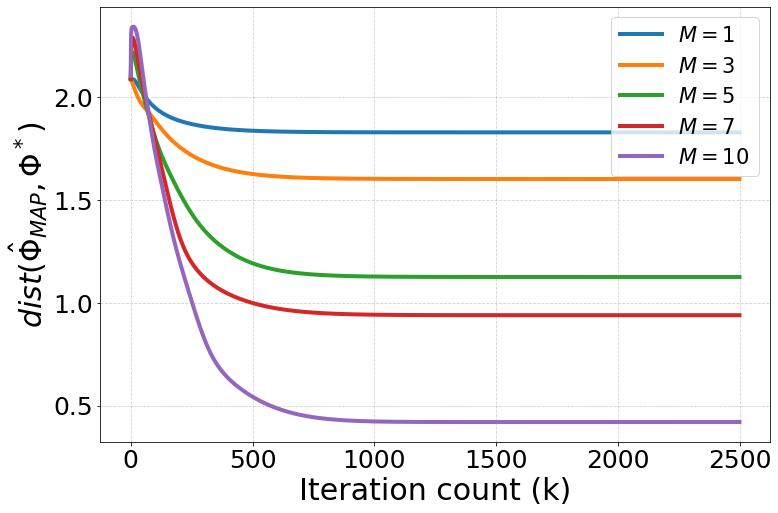

In [527]:
# Create a plot to show the convergence of the Gibbs Sampler (Log-joint vs iterations)
fig, ax = plt.subplots(figsize=(12,8))


# Plot the data
ax.plot(list(range(int(K))), Error_CAMAP_1, label=r'$M = 1$ ', linestyle='-', linewidth=4)
ax.plot(list(range(int(K))), Error_CAMAP_3, label=r'$M = 3$ ', linestyle='-', linewidth=4)
ax.plot(list(range(int(K))), Error_CAMAP_5, label=r'$M = 5$ ', linestyle='-', linewidth=4)
ax.plot(list(range(int(K))), Error_CAMAP_7, label=r'$M = 7$ ', linestyle='-', linewidth=4)
ax.plot(list(range(int(K))), Error_CAMAP_10, label=r'$M = 10$ ', linestyle='-', linewidth=4)
ax.plot(list(range(int(K))), Error_CAMAP_10, label=r'$M = 10$ ', linestyle='-', linewidth=4)

# Set labels and a title
ax.set_xlabel('Iteration count (k)',fontsize=30)
ax.set_ylabel(r'$dist(\hat{\Phi}_{MAP},\Phi^*)$',fontsize=30)
ax.tick_params(axis='both', labelsize=25)
plt.legend()
handles, labels = plt.gca().get_legend_handles_labels()
handles = handles[:5]  
labels = labels[:5] 
plt.legend(handles=handles, labels=labels,fontsize=21)

# Customize the grid
ax.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()